In [1]:
from __future__ import division
import sys
import argparse
import configparser
import json
import h5py as h5
import os
from os.path import isfile
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from sklearn import linear_model
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from sklearn.utils import shuffle

In [2]:
config = configparser.ConfigParser()
my_config = '/home/jovyan/Project/Config/default.cfg'
with open('/home/jovyan/Project/Config/default.cfg', 'r') as f:
    config.read_file(f)

dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')
preproc_path = dsgv_home + '/Preproc/PreprocOut/'
feats_path = dsgv_home + '/ExtractFeats/ExtractOut/'
wac_path = dsgv_home + '/WACs/'


# The first 3 features in the image feature Xs encode the corpus ID, image ID, region ID
ID_FEATS = 3

In [3]:
# Define classifier
classifier = linear_model.LogisticRegression
classf_params = {
    'penalty': 'l2',
    'warm_start': True,
    'solver': 'sag',
    'max_iter': 500
}

# Model description:
model = {
    'rcorp': 'flickr30k',        # ref corpus
    'cnn': 'rsn50-flatten_1',        # CNN used for vision feats
    'rel':   'excl',           # exclude relational expressions
    'wrdl':  'min',            # wordlist: minimal n occurrences...
    'wprm':  40,               # ... 40 times
    'clsf':  'logreg-l2',      # logistic regression, l1 regularized
    'params': classf_params,
    'scaled': True,
    'nneg':  'balanced',       # maximum neg instances
    'nsrc':  'randmax',        # ... randomly selected
    'notes': ''
}

# Data

In [4]:
with open(preproc_path + 'flickr30k_split.json', 'r') as f:
    rc_splits = json.load(f)

In [5]:
# image features
with h5.File(feats_path + 'flickr_bbdf_rsn50-max_all.hdf5') as f:
    X = np.array(f["img_feats"])

In [6]:
def filter_X_by_filelist(X, filelist):
    tmp_df = pd.DataFrame(X)
    tmp_df = tmp_df[tmp_df.iloc[:,1].isin(filelist)]
    X_t = tmp_df.to_numpy()
    return X_t

def filter_refdf_by_filelist(refdf, filelist):
    return pd.merge(refdf, pd.DataFrame(filelist, columns=['image_id']))

In [7]:
X_t = filter_X_by_filelist(X, rc_splits['train'])

In [8]:
print(len(X_t))

258802


In [11]:
#referring expressions - EN
flickr30k_refdf = pd.read_json(preproc_path + 'flickr_objdf.json.gz',
                                typ='frame', orient='split', compression='gzip')
refdf_train = filter_refdf_by_filelist(flickr30k_refdf, rc_splits['train'])

In [12]:
refdf_train

,i_corpus,image_id,region_id,phrase,cat
0,8,3187924573,99601,Two seagulls,animals
1,8,3187924573,99604,water,scene
2,8,3187924573,99600,foreground bird,animals
3,8,3187924573,99603,object,other
4,8,3187924573,99602,beak,bodyparts
...,...,...,...,...,...
524860,8,408748500,154756,A child,people
524861,8,408748500,154757,a coat,clothing
524862,8,408748500,154760,someone,people
524863,8,408748500,154756,a boy,people


# Intermediate

In [13]:
def create_word2den(refdf, refcol, regcol='region_id'):
    '''Given refdf, returns dict of occurences (id triples) of words from expressions.'''
    word2den = defaultdict(list)
    for _, row in refdf.iterrows():
        exprlist = row[refcol].split()
        for word in exprlist:
            word = word.lower()
            word_den_list = word2den[word].append((row['i_corpus'],
                                                   row['image_id'],
                                                   row[regcol]))
    return {k: list(set(v)) for k,v in word2den.items()}

In [14]:
%%time
word2den_en = create_word2den(refdf_train, refcol='phrase')

CPU times: user 27.8 s, sys: 176 ms, total: 28 s
Wall time: 28.1 s


In [15]:
len(word2den_en)

16698

In [17]:
with open(wac_path + 'ModelsOut/flickr_word2den_en.pkl', 'wb') as f:
    pickle.dump(word2den_en, f)
with open(wac_path + 'ModelsOut/flickr_word2den_en.pkl', 'rb') as f:
    word2den_en = pickle.load(f)

In [18]:
def make_X_id_index(X, id_feats=ID_FEATS):
    return dict(zip([tuple(e) for e in X[:,:id_feats].astype(int).tolist()], range(len(X))))

In [19]:
%%time
X_idx = make_X_id_index(X_t)

CPU times: user 819 ms, sys: 25.9 ms, total: 845 ms
Wall time: 848 ms


In [20]:
len(X_idx)

169943

In [21]:
def make_mask_matrix(X, X_idx, word2den, wordlist):
    mask_matrix = []
    for this_word in wordlist:
        this_word_vec = np.zeros(len(X))
        if this_word in word2den:
          this_word_vec[[X_idx[i] for i in word2den[this_word] if i in X_idx]] = 1
        mask_matrix.append(this_word_vec)
    mask_matrix = np.array(mask_matrix, dtype=bool)
    return mask_matrix

In [22]:
%%time
mask_matrix_en = make_mask_matrix(X_t, X_idx, word2den_en, word2den_en.keys())

CPU times: user 9.43 s, sys: 7.62 s, total: 17 s
Wall time: 17.2 s


In [23]:
mask_matrix_en.shape

(16698, 258802)

In [25]:
np.savez(wac_path + 'ModelsOut/flickr_mask_matrix_en.npz', arr_0=mask_matrix_en)

In [26]:
mask_matrix_en = np.load(wac_path + 'ModelsOut/flickr_mask_matrix_en.npz')['arr_0']

# Wordlist

In [27]:
min_freq = model['wprm']
counts_en = mask_matrix_en.sum(axis=1)
wordlist_en = np.array(list(word2den_en.keys()))[counts_en > min_freq]

In [28]:
def get_X_for_word(X, word2den, mask_matrix, word, neg_max):
    if word not in word2den:
        print ("Error!! No mask available for this word! (%s)" % (word))
        return None
    this_mask = mask_matrix[list(word2den.keys()).index(word)]
    X_pos = X[this_mask, ID_FEATS:]
    y_pos = np.ones(len(X_pos), dtype=int)

    if type(neg_max) is int or type(neg_max) is str:
        if neg_max == 0:
            return X_pos, y_pos
        if neg_max == 'balanced':
            neg_max = len(y_pos)
    
        neg_indx = np.arange(mask_matrix.shape[1])[~this_mask]
        np.random.shuffle(neg_indx)
        X_neg = X[neg_indx[:neg_max], ID_FEATS:]
    else:
        X_neg = neg_max
    y_neg = np.zeros(len(X_neg), dtype=int)

    X_out = np.concatenate([X_pos, X_neg], axis=0)
    y_out = np.concatenate([y_pos, y_neg])
    return shuffle(X_out, y_out)

In [29]:
def make_train_for_word(X, word2den, mask_matrix, word, neg_max=20000):
    if word not in word2den:
        print("Error!! No mask available for this word! (%s)" % (word))
        return None
    this_mask = mask_matrix[list(word2den.keys()).index(word)]
    X_pos = X[this_mask, ID_FEATS:]
    y_pos = np.ones(len(X_pos), dtype=int)
    
    neg_indx = np.arange(mask_matrix.shape[1])[~this_mask]
    np.random.shuffle(neg_indx)
    X_neg = X[neg_indx[:len(y_pos)], ID_FEATS:]
    y_neg = np.zeros(len(X_neg), dtype=int)

    X_out = np.concatenate([X_pos, X_neg], axis=0)
    y_out = np.concatenate([y_pos, y_neg])
    return shuffle(X_out, y_out)

In [31]:
# %%time
X_this_w, y_this_w = make_train_for_word(X_t, word2den_en, mask_matrix_en, 'two')

In [32]:
print(X_this_w.shape)

(14048, 2055)


In [33]:
print(len(y_this_w))

14048


Reduce the set of words for which WAC is trained, by frequency:

# Train

Train the baseline wac

For logistic regression, we use l2 penalty and 'sag' solver.
Use this as baseline model.

In [42]:
wacs_en = []
for this_word in tqdm(wordlist_en):
    X_this_w, y_this_w = get_X_for_word(X_t, word2den_en, mask_matrix_en, this_word,neg_max='balanced')
    print(this_word, X_this_w.shape[0])
    classifier = linear_model.LogisticRegression(penalty='l2', warm_start=True, solver='sag')
    this_wac = classifier.fit(X_this_w, y_this_w)
    wacs_en.append((this_word, y_this_w.sum(), len(X_this_w), this_wac))

  0%|          | 0/1207 [00:00<?, ?it/s]

two 14048


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 1/1207 [00:26<9:01:27, 26.94s/it]

water 4592


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 2/1207 [00:37<5:50:31, 17.45s/it]

bird 242


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 5/1207 [06:12<41:29:24, 124.26s/it]

white 16232


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 6/1207 [06:43<30:52:09, 92.53s/it] 

something 1250


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 7/1207 [06:45<20:57:44, 62.89s/it]

its 1312


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 8/1207 [06:47<14:29:02, 43.49s/it]

the 51052


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 9/1207 [08:15<19:08:42, 57.53s/it]

large 6632


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 10/1207 [08:27<14:27:36, 43.49s/it]

fish 310


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 11/1207 [08:28<10:06:01, 30.40s/it]

boy 6720


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 12/1207 [08:43<8:32:59, 25.76s/it] 

blue 13786


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 13/1207 [09:10<8:38:41, 26.07s/it]

baseball 1384


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 14/1207 [09:12<6:13:59, 18.81s/it]

hat 4382


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 15/1207 [09:18<4:59:24, 15.07s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|▏         | 16/1207 [09:19<3:30:17, 10.59s/it]

bars 134
young 15972


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|▏         | 17/1207 [09:44<4:59:55, 15.12s/it]

child 5374


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|▏         | 18/1207 [09:53<4:20:08, 13.13s/it]

hands 2042


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 19/1207 [09:58<3:29:57, 10.60s/it]

an 17256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 20/1207 [10:35<6:06:21, 18.52s/it]

adult 720


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 21/1207 [10:36<4:22:26, 13.28s/it]

someone 1128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 22/1207 [10:38<3:18:47, 10.07s/it]

ladder 260


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 23/1207 [10:39<2:22:34,  7.22s/it]

little 5632


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 24/1207 [10:52<2:55:33,  8.90s/it]

toddler 904


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 25/1207 [10:53<2:11:02,  6.65s/it]

park 1040


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 26/1207 [10:55<1:41:30,  5.16s/it]

three 4688


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 27/1207 [11:05<2:11:17,  6.68s/it]

friends 586


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 28/1207 [11:06<1:37:01,  4.94s/it]

boat 966


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 29/1207 [11:07<1:17:29,  3.95s/it]

bright 1218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 30/1207 [11:10<1:10:23,  3.59s/it]

rocky 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 31/1207 [11:11<54:40,  2.79s/it]  

shore 412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 32/1207 [11:12<43:34,  2.23s/it]

shirtless 610


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 33/1207 [11:13<38:20,  1.96s/it]

men 7962


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 34/1207 [11:27<1:44:26,  5.34s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 35/1207 [11:27<1:13:56,  3.79s/it]

paddle 106
man 25112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 36/1207 [12:14<5:26:31, 16.73s/it]

other 3246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 37/1207 [12:20<4:25:45, 13.63s/it]

people 15856


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 38/1207 [12:50<6:02:39, 18.61s/it]

boys 1854


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 39/1207 [12:53<4:29:32, 13.85s/it]

colorful 1432


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 40/1207 [12:55<3:22:04, 10.39s/it]

plastic 744


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 41/1207 [12:57<2:31:08,  7.78s/it]

building 3264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 42/1207 [13:03<2:22:48,  7.36s/it]

toys 298


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▎         | 43/1207 [13:04<1:42:36,  5.29s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▎         | 44/1207 [13:04<1:12:45,  3.75s/it]

cute 114
blocks 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▎         | 45/1207 [13:04<52:27,  2.71s/it]  

baby 1338


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 46/1207 [13:07<54:08,  2.80s/it]

his 14210


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 47/1207 [13:31<2:52:48,  8.94s/it]

toy 1076


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 48/1207 [13:32<2:10:00,  6.73s/it]

set 394


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 49/1207 [13:33<1:34:27,  4.89s/it]

dark-skinned 250


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 50/1207 [13:33<1:08:16,  3.54s/it]

girl 7048


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 51/1207 [13:45<1:57:24,  6.09s/it]

her 7708


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 52/1207 [13:57<2:32:55,  7.94s/it]

sneakers 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 53/1207 [13:58<1:49:31,  5.69s/it]

spectators 528


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 54/1207 [13:59<1:23:10,  4.33s/it]

's 2570


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 55/1207 [14:05<1:30:58,  4.74s/it]

shoes 858


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 56/1207 [14:06<1:13:50,  3.85s/it]

stand 540


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 57/1207 [14:08<58:30,  3.05s/it]  

group 9174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 58/1207 [14:27<2:34:43,  8.08s/it]

of 29378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 59/1207 [15:22<6:58:39, 21.88s/it]

indian 466


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▍         | 60/1207 [15:22<4:56:54, 15.53s/it]

girls 2352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 61/1207 [15:26<3:48:05, 11.94s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 62/1207 [15:26<2:40:40,  8.42s/it]

shoe 118
several 3434


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 63/1207 [15:31<2:21:56,  7.44s/it]

women 4806


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 64/1207 [15:39<2:22:34,  7.48s/it]

yellow 5200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 65/1207 [15:47<2:24:11,  7.58s/it]

table 2514


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  5%|▌         | 66/1207 [15:50<2:01:57,  6.41s/it]

line 738


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 67/1207 [15:51<1:31:37,  4.82s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 68/1207 [15:52<1:04:48,  3.41s/it]

carnival 84
game 484


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 69/1207 [15:52<49:19,  2.60s/it]  

one 5716


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 70/1207 [16:01<1:24:50,  4.48s/it]

woman 14048


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 71/1207 [16:23<3:02:10,  9.62s/it]

right 516


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 72/1207 [16:24<2:11:57,  6.98s/it]

arm 858


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 73/1207 [16:25<1:39:38,  5.27s/it]

lady 3118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 74/1207 [16:32<1:48:26,  5.74s/it]

glass 636


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 75/1207 [16:33<1:24:12,  4.46s/it]

picnic 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▋         | 76/1207 [16:33<1:00:42,  3.22s/it]

stuffed 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▋         | 77/1207 [16:34<44:51,  2.38s/it]  

side 972


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▋         | 78/1207 [16:36<43:54,  2.33s/it]

blanket 334


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 79/1207 [16:37<35:06,  1.87s/it]

all 1144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 80/1207 [16:39<39:05,  2.08s/it]

animal 388


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 81/1207 [16:40<32:10,  1.71s/it]

grass 2088


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 82/1207 [16:45<48:46,  2.60s/it]

black 15448


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 83/1207 [17:11<2:59:25,  9.58s/it]

and 8352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 84/1207 [17:25<3:25:33, 10.98s/it]

red 11014


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 85/1207 [17:42<3:56:17, 12.64s/it]

striped 1666


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 86/1207 [17:44<2:59:11,  9.59s/it]

shirt 15714


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 87/1207 [18:10<4:30:17, 14.48s/it]

photo 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 88/1207 [18:10<3:10:57, 10.24s/it]

statue 350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 89/1207 [18:11<2:16:24,  7.32s/it]

older 3040


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  7%|▋         | 90/1207 [18:15<2:00:28,  6.47s/it]

gentleman 654


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 91/1207 [18:16<1:29:33,  4.81s/it]

polo 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 92/1207 [18:17<1:04:34,  3.47s/it]

sculpture 220


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 93/1207 [18:17<47:04,  2.54s/it]  

tree 1322


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 94/1207 [18:19<43:38,  2.35s/it]

dog 4278


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 95/1207 [18:25<1:05:57,  3.56s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 96/1207 [18:25<47:08,  2.55s/it]  

branch 120
their 4712


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 97/1207 [18:33<1:12:56,  3.94s/it]

glasses 2102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 98/1207 [18:36<1:08:05,  3.68s/it]

corner 308


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 99/1207 [18:36<50:21,  2.73s/it]  

book 548


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 100/1207 [18:37<39:46,  2.16s/it]

shop 532


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 101/1207 [18:38<32:09,  1.75s/it]

green 6096


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 102/1207 [18:47<1:12:30,  3.94s/it]

walls 226


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▊         | 103/1207 [18:47<52:33,  2.86s/it]  

meal 326


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▊         | 104/1207 [18:48<39:28,  2.15s/it]

elderly 1320


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▊         | 105/1207 [18:50<38:35,  2.10s/it]

coffee 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 106/1207 [18:50<30:13,  1.65s/it]

jacket 4262


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 107/1207 [18:59<1:11:23,  3.89s/it]

snowboarder 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 108/1207 [19:00<53:16,  2.91s/it]  

board 700


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 109/1207 [19:02<45:41,  2.50s/it]

left 466


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 110/1207 [19:03<37:52,  2.07s/it]

snow 1614


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 111/1207 [19:06<47:36,  2.61s/it]

mountain 994


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 112/1207 [19:09<45:15,  2.48s/it]

or 692


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 113/1207 [19:10<40:02,  2.20s/it]

snowboard 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  9%|▉         | 114/1207 [19:11<30:03,  1.65s/it]

guy 2340


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 115/1207 [19:15<44:27,  2.44s/it]

necklace 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 116/1207 [19:15<32:23,  1.78s/it]

another 2814


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 117/1207 [19:19<45:29,  2.50s/it]

store 828


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 118/1207 [19:21<38:29,  2.12s/it]

window 974


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 119/1207 [19:22<35:10,  1.94s/it]

jewelry 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 120/1207 [19:22<26:09,  1.44s/it]

market 264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 121/1207 [19:23<21:27,  1.19s/it]

gray 3116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 122/1207 [19:30<50:45,  2.81s/it]

camouflage 230


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 123/1207 [19:30<37:22,  2.07s/it]

pants 2920


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 124/1207 [19:34<49:25,  2.74s/it]

hood 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 125/1207 [19:34<35:53,  1.99s/it]

truck 666


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|█         | 126/1207 [19:35<30:18,  1.68s/it]

shade 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 127/1207 [19:36<22:31,  1.25s/it]

professional 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 128/1207 [19:36<18:40,  1.04s/it]

soccer 1528


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 129/1207 [19:40<31:30,  1.75s/it]

players 1142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 130/1207 [19:42<35:24,  1.97s/it]

stadium 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 131/1207 [19:42<26:06,  1.46s/it]

player 1862


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 132/1207 [19:46<40:32,  2.26s/it]

ball 2686


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 133/1207 [19:52<1:00:12,  3.36s/it]

athletes 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 134/1207 [19:53<43:38,  2.44s/it]  

purple 1562


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█         | 135/1207 [19:56<49:02,  2.74s/it]

stripes 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█▏        | 136/1207 [19:57<36:37,  2.05s/it]

field 2104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█▏        | 137/1207 [20:00<43:52,  2.46s/it]

pedestrians 326


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 11%|█▏        | 138/1207 [20:00<33:15,  1.87s/it]

bikes 472


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 139/1207 [20:01<26:54,  1.51s/it]

nice 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 140/1207 [20:01<19:56,  1.12s/it]

bike 2430


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 141/1207 [20:05<35:22,  1.99s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 142/1207 [20:06<25:50,  1.46s/it]

sunny 90
day 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 143/1207 [20:06<20:00,  1.13s/it]

small 5434


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 144/1207 [20:18<1:17:09,  4.35s/it]

street 5440


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 145/1207 [20:26<1:37:23,  5.50s/it]

few 626


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 146/1207 [20:27<1:15:22,  4.26s/it]

brown 5524


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 147/1207 [20:39<1:54:58,  6.51s/it]

ocean 994


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 148/1207 [20:41<1:28:29,  5.01s/it]

waves 326


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 149/1207 [20:41<1:04:34,  3.66s/it]

beach 1332


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▏        | 150/1207 [20:43<55:55,  3.17s/it]  

feet 436


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 151/1207 [20:44<42:31,  2.42s/it]

sea 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 152/1207 [20:44<31:14,  1.78s/it]

light 1230


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 153/1207 [20:46<31:49,  1.81s/it]

t-shirt 2100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 154/1207 [20:49<39:04,  2.23s/it]

pink 3184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 155/1207 [20:54<53:23,  3.05s/it]

backpack 690


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 156/1207 [20:55<43:02,  2.46s/it]

hand 2922


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 157/1207 [21:00<54:06,  3.09s/it]

blond-hair 608


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 158/1207 [21:01<42:53,  2.45s/it]

mountains 422


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 159/1207 [21:02<35:09,  2.01s/it]

trees 1292


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 160/1207 [21:05<39:39,  2.27s/it]

bushes 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 161/1207 [21:05<28:55,  1.66s/it]

head 1892


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 13%|█▎        | 162/1207 [21:08<36:29,  2.10s/it]

hair 3188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▎        | 163/1207 [21:13<52:07,  3.00s/it]

looking 326


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▎        | 164/1207 [21:14<39:02,  2.25s/it]

view 290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▎        | 165/1207 [21:14<29:38,  1.71s/it]

dirt 1456


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 166/1207 [21:16<32:08,  1.85s/it]

stick 682


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 167/1207 [21:17<28:02,  1.62s/it]

shoulder 534


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 168/1207 [21:18<23:51,  1.38s/it]

camera 652


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 169/1207 [21:19<22:01,  1.27s/it]

this 1052


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 170/1207 [21:21<23:54,  1.38s/it]

wave 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 171/1207 [21:21<19:56,  1.15s/it]

children 3794


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 172/1207 [21:29<54:26,  3.16s/it]

surf 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 173/1207 [21:30<39:49,  2.31s/it]

wall 2436


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 174/1207 [21:34<48:41,  2.83s/it]

video 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 14%|█▍        | 175/1207 [21:34<35:39,  2.07s/it]

coat 1828


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 176/1207 [21:37<39:34,  2.30s/it]

skateboard 656


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 177/1207 [21:38<32:45,  1.91s/it]

air 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 178/1207 [21:38<24:29,  1.43s/it]

some 4750


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 179/1207 [21:49<1:13:33,  4.29s/it]

tracks 194


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 180/1207 [21:49<53:45,  3.14s/it]  

skateboarder 468


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▍        | 181/1207 [21:51<43:03,  2.52s/it]

train 628


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 182/1207 [21:52<37:38,  2.20s/it]

railroad 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 183/1207 [21:52<28:22,  1.66s/it]

track 640


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 184/1207 [21:54<27:41,  1.62s/it]

mat 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 185/1207 [21:54<21:48,  1.28s/it]

parking 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 186/1207 [21:55<17:51,  1.05s/it]

lot 630


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 187/1207 [21:56<18:05,  1.06s/it]

open 700


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 188/1207 [21:57<18:01,  1.06s/it]

door 532


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 189/1207 [21:58<18:39,  1.10s/it]

middle 512


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 190/1207 [21:59<19:02,  1.12s/it]

busy 538


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 191/1207 [22:01<19:26,  1.15s/it]

heavy 290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 192/1207 [22:01<17:01,  1.01s/it]

traffic 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 193/1207 [22:02<14:05,  1.20it/s]

shorts 2788


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 194/1207 [22:08<43:05,  2.55s/it]

outside 926


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 195/1207 [22:10<40:56,  2.43s/it]

sign 1256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▌        | 196/1207 [22:13<42:59,  2.55s/it]

box 400


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▋        | 197/1207 [22:14<35:10,  2.09s/it]

electric 366


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▋        | 198/1207 [22:15<28:55,  1.72s/it]

poster 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 16%|█▋        | 199/1207 [22:16<21:57,  1.31s/it]

construction 1214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 200/1207 [22:18<29:10,  1.74s/it]

worker 816


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 201/1207 [22:20<29:49,  1.78s/it]

cellphone 710


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 202/1207 [22:22<29:17,  1.75s/it]

pipe 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 203/1207 [22:22<22:34,  1.35s/it]

phone 668


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 204/1207 [22:24<23:23,  1.40s/it]

long 1878


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 205/1207 [22:28<37:58,  2.27s/it]

hose 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 206/1207 [22:28<28:11,  1.69s/it]

couple 1552


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 207/1207 [22:32<37:40,  2.26s/it]

workers 1104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 208/1207 [22:34<36:58,  2.22s/it]

new 282


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 209/1207 [22:35<28:01,  1.68s/it]

tank 960


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 210/1207 [22:36<27:12,  1.64s/it]

top 2564


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 17%|█▋        | 211/1207 [22:40<39:07,  2.36s/it]

tie 308


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 212/1207 [22:41<30:59,  1.87s/it]

color 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 213/1207 [22:41<23:22,  1.41s/it]

brunette 404


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 214/1207 [22:42<20:59,  1.27s/it]

maroon 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 215/1207 [22:43<17:02,  1.03s/it]

dark 2076


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 216/1207 [22:47<35:00,  2.12s/it]

pole 662


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 217/1207 [22:48<29:21,  1.78s/it]

adults 884


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 218/1207 [22:50<27:08,  1.65s/it]

each 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 219/1207 [22:50<21:21,  1.30s/it]

dirty 286


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 220/1207 [22:51<17:08,  1.04s/it]

alley 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 221/1207 [22:51<13:18,  1.24it/s]

sidewalk 2614


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 222/1207 [22:57<38:22,  2.34s/it]

pile 394


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 18%|█▊        | 223/1207 [22:58<31:16,  1.91s/it]

wood 620


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▊        | 224/1207 [22:59<28:58,  1.77s/it]

river 716


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▊        | 225/1207 [23:01<28:10,  1.72s/it]

body 982


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▊        | 226/1207 [23:03<30:16,  1.85s/it]

nearby 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 227/1207 [23:03<22:39,  1.39s/it]

tan 1406


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 228/1207 [23:06<32:10,  1.97s/it]

golden 276


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 229/1207 [23:07<25:38,  1.57s/it]

dogs 1246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 230/1207 [23:10<31:40,  1.94s/it]

sand 884


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 231/1207 [23:12<31:57,  1.97s/it]

kids 1676


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 232/1207 [23:15<37:20,  2.30s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 233/1207 [23:15<27:07,  1.67s/it]

parents 128
lots 282


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 234/1207 [23:16<21:01,  1.30s/it]

jeans 2668


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 19%|█▉        | 235/1207 [23:22<43:29,  2.68s/it]

vest 890


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 236/1207 [23:23<37:09,  2.30s/it]

jean 288


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 237/1207 [23:23<28:04,  1.74s/it]

denim 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 238/1207 [23:24<21:23,  1.32s/it]

army 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 239/1207 [23:24<16:24,  1.02s/it]

suit 1616


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 240/1207 [23:28<29:54,  1.86s/it]

suits 492


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|█▉        | 241/1207 [23:29<25:33,  1.59s/it]

military 414


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 242/1207 [23:29<20:50,  1.30s/it]

uniforms 994


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 243/1207 [23:31<21:38,  1.35s/it]

onlookers 562


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 244/1207 [23:32<19:05,  1.19s/it]

member 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 245/1207 [23:32<14:37,  1.10it/s]

picture 908


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 246/1207 [23:33<16:44,  1.05s/it]

volleyball 316


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|██        | 247/1207 [23:34<13:58,  1.15it/s]

teams 372


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 248/1207 [23:34<12:26,  1.29it/s]

floor 1054


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 249/1207 [23:36<16:17,  1.02s/it]

hard 580


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 250/1207 [23:37<15:34,  1.02it/s]

court 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 251/1207 [23:37<12:27,  1.28it/s]

short 684


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 252/1207 [23:38<13:43,  1.16it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 253/1207 [23:38<10:23,  1.53it/s]

silhouette 106
sun 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 254/1207 [23:39<09:18,  1.71it/s]

ledge 380


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 255/1207 [23:40<10:24,  1.52it/s]

snowy 504


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██        | 256/1207 [23:41<12:34,  1.26it/s]

hill 650


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██▏       | 257/1207 [23:42<15:31,  1.02it/s]

eight 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██▏       | 258/1207 [23:42<12:20,  1.28it/s]

clouds 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 21%|██▏       | 259/1207 [23:43<09:51,  1.60it/s]

hikers 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 260/1207 [23:43<08:34,  1.84it/s]

tops 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 261/1207 [23:43<07:56,  1.99it/s]

asian 2786


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 262/1207 [23:50<34:58,  2.22s/it]

style 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 263/1207 [23:50<26:01,  1.65s/it]

gate 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 264/1207 [23:50<20:12,  1.29s/it]

newspaper 304


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 265/1207 [23:51<17:22,  1.11s/it]

part 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 266/1207 [23:51<13:31,  1.16it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 267/1207 [23:52<10:26,  1.50it/s]

town 92
front 420


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 268/1207 [23:53<11:59,  1.31it/s]

room 530


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 269/1207 [23:54<13:52,  1.13it/s]

chairs 574


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 270/1207 [23:55<15:43,  1.01s/it]

audience 588


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 22%|██▏       | 271/1207 [23:56<17:03,  1.09s/it]

sweatshirt 712


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 272/1207 [23:58<19:39,  1.26s/it]

legs 464


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 273/1207 [23:59<18:28,  1.19s/it]

steel 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 274/1207 [23:59<14:17,  1.09it/s]

platform 332


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 275/1207 [24:00<13:24,  1.16it/s]

laptop 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 276/1207 [24:01<11:20,  1.37it/s]

overweight 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 277/1207 [24:01<09:01,  1.72it/s]

hooded 268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 278/1207 [24:01<09:07,  1.70it/s]

computer 460


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 279/1207 [24:02<11:05,  1.39it/s]

outdoors 266


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 280/1207 [24:03<10:31,  1.47it/s]

bench 1204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 281/1207 [24:06<20:25,  1.32s/it]

ladies 706


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 282/1207 [24:07<21:45,  1.41s/it]

pajamas 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 283/1207 [24:08<16:43,  1.09s/it]

neon 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▎       | 284/1207 [24:08<13:47,  1.12it/s]

shirts 1298


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▎       | 285/1207 [24:11<23:06,  1.50s/it]

microscope 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▎       | 286/1207 [24:11<17:21,  1.13s/it]

students 452


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 287/1207 [24:12<16:54,  1.10s/it]

class 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 288/1207 [24:13<14:06,  1.09it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 289/1207 [24:13<10:43,  1.43it/s]

classroom 82
flowers 612


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 290/1207 [24:14<13:41,  1.12it/s]

basket 316


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 291/1207 [24:15<13:01,  1.17it/s]

back 1014


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 292/1207 [24:17<19:20,  1.27s/it]

bicycle 1626


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 293/1207 [24:21<30:05,  1.98s/it]

fresh 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 294/1207 [24:21<22:39,  1.49s/it]

both 258


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 24%|██▍       | 295/1207 [24:22<18:29,  1.22s/it]

brick 1016


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 296/1207 [24:24<23:09,  1.52s/it]

saxophone 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 297/1207 [24:24<17:21,  1.14s/it]

old 2164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 298/1207 [24:29<34:03,  2.25s/it]

african 754


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 299/1207 [24:31<31:20,  2.07s/it]

american 736


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 300/1207 [24:33<29:34,  1.96s/it]

windows 240


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▍       | 301/1207 [24:33<23:05,  1.53s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 302/1207 [24:33<17:04,  1.13s/it]

lift 86
tall 688


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 303/1207 [24:35<18:45,  1.25s/it]

rug 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 304/1207 [24:35<14:12,  1.06it/s]

same 238


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 305/1207 [24:36<12:24,  1.21it/s]

carpet 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 306/1207 [24:36<09:56,  1.51it/s]

tag 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 307/1207 [24:36<07:58,  1.88it/s]

backpacks 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 308/1207 [24:37<07:11,  2.08it/s]

four 2268


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 309/1207 [24:41<23:50,  1.59s/it]

path 824


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 310/1207 [24:42<22:01,  1.47s/it]

trail 390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 311/1207 [24:43<18:03,  1.21s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 312/1207 [24:43<13:31,  1.10it/s]

desert 124
school 372


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 313/1207 [24:43<11:51,  1.26it/s]

, 2530


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 314/1207 [24:47<24:55,  1.67s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 315/1207 [24:47<18:07,  1.22s/it]

there 106
casual 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▌       | 316/1207 [24:47<13:31,  1.10it/s]

clothes 1250


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▋       | 317/1207 [24:49<17:32,  1.18s/it]

ear 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▋       | 318/1207 [24:49<13:35,  1.09it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 26%|██▋       | 319/1207 [24:50<10:05,  1.47it/s]

cheek 82
stunt 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 320/1207 [24:50<07:50,  1.88it/s]

uniform 1676


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 321/1207 [24:52<16:33,  1.12s/it]

lines 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 322/1207 [24:53<12:44,  1.16it/s]

number 786


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 323/1207 [24:54<16:22,  1.11s/it]

3 484


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 324/1207 [24:55<16:04,  1.09s/it]

play 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 325/1207 [24:56<12:42,  1.16it/s]

jersey 660


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 326/1207 [24:57<15:23,  1.05s/it]

roller 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 327/1207 [24:57<11:55,  1.23it/s]

guitar 1204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 328/1207 [25:00<20:16,  1.38s/it]

bag 1096


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 329/1207 [25:03<25:12,  1.72s/it]

lap 274


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 330/1207 [25:03<20:16,  1.39s/it]

public 334


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 27%|██▋       | 331/1207 [25:04<17:23,  1.19s/it]

subway 230


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 332/1207 [25:04<14:21,  1.02it/s]

others 956


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 333/1207 [25:07<19:51,  1.36s/it]

city 1350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 334/1207 [25:10<27:07,  1.86s/it]

crowded 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 335/1207 [25:10<21:29,  1.48s/it]

area 876


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 336/1207 [25:12<23:25,  1.61s/it]

bicyclist 288


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 337/1207 [25:13<19:12,  1.32s/it]

road 1714


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 338/1207 [25:16<28:33,  1.97s/it]

helmet 1256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 339/1207 [25:18<27:45,  1.92s/it]

person 5500


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 340/1207 [25:28<1:00:36,  4.19s/it]

orange 3474


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 341/1207 [25:33<1:06:49,  4.63s/it]

foreign 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 342/1207 [25:34<47:56,  3.33s/it]  

country 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 28%|██▊       | 343/1207 [25:34<34:27,  2.39s/it]

tables 382


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 344/1207 [25:34<26:56,  1.87s/it]

tourists 194


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 345/1207 [25:35<20:04,  1.40s/it]

streets 244


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 346/1207 [25:35<15:38,  1.09s/it]

restaurant 434


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▊       | 347/1207 [25:36<13:39,  1.05it/s]

cafe 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 348/1207 [25:36<10:44,  1.33it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 349/1207 [25:36<08:22,  1.71it/s]

towel 130
mask 302


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 350/1207 [25:37<07:48,  1.83it/s]

rocks 658


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 351/1207 [25:38<11:35,  1.23it/s]

lake 818


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 352/1207 [25:40<16:13,  1.14s/it]

kid 1006


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 353/1207 [25:42<20:47,  1.46s/it]

neck 262


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 354/1207 [25:43<16:59,  1.19s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 355/1207 [25:43<12:46,  1.11it/s]

scuba 90
goggles 306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 29%|██▉       | 356/1207 [25:44<11:56,  1.19it/s]

leaves 290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 357/1207 [25:44<11:07,  1.27it/s]

plaid 690


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 358/1207 [25:46<14:11,  1.00s/it]

cap 1528


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 359/1207 [25:49<24:19,  1.72s/it]

crowd 3440


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 360/1207 [25:55<42:17,  3.00s/it]

bucket 342


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 361/1207 [25:56<31:41,  2.25s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|██▉       | 362/1207 [25:56<22:47,  1.62s/it]

word 96
rope 572


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 363/1207 [25:57<19:33,  1.39s/it]

sleeves 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 364/1207 [25:57<14:38,  1.04s/it]

curly 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 365/1207 [25:57<12:10,  1.15it/s]

gloves 488


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 366/1207 [25:59<12:59,  1.08it/s]

shopping 414


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 367/1207 [25:59<12:54,  1.08it/s]

karate 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|███       | 368/1207 [26:00<10:33,  1.32it/s]

post 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 369/1207 [26:00<09:13,  1.51it/s]

sunglasses 1420


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 370/1207 [26:04<20:13,  1.45s/it]

leg 396


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 371/1207 [26:04<17:49,  1.28s/it]

friend 216


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 372/1207 [26:05<14:35,  1.05s/it]

mouth 1346


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 373/1207 [26:08<23:06,  1.66s/it]

eyes 534


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 374/1207 [26:09<20:01,  1.44s/it]

ears 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 375/1207 [26:09<15:02,  1.08s/it]

no 414


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 376/1207 [26:10<13:13,  1.05it/s]

faces 304


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███       | 377/1207 [26:10<11:01,  1.25it/s]

can 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 378/1207 [26:10<08:40,  1.59it/s]

beer 388


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 379/1207 [26:11<09:33,  1.44it/s]

2 680


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 31%|███▏      | 380/1207 [26:13<13:02,  1.06it/s]

bathing 450


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 381/1207 [26:14<13:12,  1.04it/s]

swimsuits 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 382/1207 [26:14<10:07,  1.36it/s]

bed 382


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 383/1207 [26:15<10:36,  1.30it/s]

swim 338


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 384/1207 [26:16<10:34,  1.30it/s]

swimming 572


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 385/1207 [26:17<12:34,  1.09it/s]

gun 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 386/1207 [26:17<10:23,  1.32it/s]

eye 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 387/1207 [26:18<08:34,  1.59it/s]

police 448


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 388/1207 [26:19<10:09,  1.34it/s]

motorcycle 702


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 389/1207 [26:20<13:36,  1.00it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 390/1207 [26:20<10:19,  1.32it/s]

motorized 82
vehicle 540


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 391/1207 [26:22<12:24,  1.10it/s]

low 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 392/1207 [26:22<10:22,  1.31it/s]

robe 224


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 393/1207 [26:23<09:34,  1.42it/s]

counter 402


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 394/1207 [26:24<10:30,  1.29it/s]

mirror 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 395/1207 [26:24<08:58,  1.51it/s]

makeup 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 396/1207 [26:25<08:24,  1.61it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 397/1207 [26:25<06:45,  2.00it/s]

sink 82
" 560


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 398/1207 [26:26<09:53,  1.36it/s]

umbrella 484


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 399/1207 [26:27<11:29,  1.17it/s]

sweater 1198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 400/1207 [26:30<19:12,  1.43s/it]

broom 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 401/1207 [26:30<14:28,  1.08s/it]

kitchen 324


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 402/1207 [26:31<13:14,  1.01it/s]

caucasian 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 403/1207 [26:32<11:11,  1.20it/s]

male 2378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 404/1207 [26:37<29:31,  2.21s/it]

blond-haired 322


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▎      | 405/1207 [26:38<23:30,  1.76s/it]

skirt 720


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▎      | 406/1207 [26:39<22:57,  1.72s/it]

shoulders 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▎      | 407/1207 [26:40<17:47,  1.33s/it]

dark-haired 490


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 408/1207 [26:41<16:57,  1.27s/it]

high 462


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 409/1207 [26:42<15:58,  1.20s/it]

heels 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 410/1207 [26:42<12:36,  1.05it/s]

computers 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 411/1207 [26:43<10:05,  1.32it/s]

full 484


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 412/1207 [26:44<11:24,  1.16it/s]

oriental 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 413/1207 [26:44<10:55,  1.21it/s]

seated 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 414/1207 [26:45<09:13,  1.43it/s]

teacher 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 415/1207 [26:45<07:45,  1.70it/s]

edge 556


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 34%|███▍      | 416/1207 [26:46<10:12,  1.29it/s]

graffiti 456


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 417/1207 [26:47<11:04,  1.19it/s]

concrete 718


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 418/1207 [26:49<13:57,  1.06s/it]

dress 2364


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 419/1207 [26:55<31:51,  2.43s/it]

flat 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 420/1207 [26:55<23:07,  1.76s/it]

screen 336


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 421/1207 [26:56<19:14,  1.47s/it]

tv 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▍      | 422/1207 [26:56<14:22,  1.10s/it]

outfit 1156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 423/1207 [26:58<20:03,  1.53s/it]

costume 700


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 424/1207 [27:00<19:59,  1.53s/it]

performer 308


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 425/1207 [27:00<16:37,  1.28s/it]

cowboy 606


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 426/1207 [27:02<16:49,  1.29s/it]

horse 724


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 427/1207 [27:03<17:57,  1.38s/it]

slide 250


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 35%|███▌      | 428/1207 [27:04<14:41,  1.13s/it]

female 2016


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 429/1207 [27:08<26:52,  2.07s/it]

blouse 302


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 430/1207 [27:09<20:36,  1.59s/it]

floral 234


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 431/1207 [27:09<15:46,  1.22s/it]

plants 240


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 432/1207 [27:09<12:26,  1.04it/s]

purse 416


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 433/1207 [27:10<11:07,  1.16it/s]

flowered 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 434/1207 [27:10<08:53,  1.45it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 435/1207 [27:10<06:50,  1.88it/s]

short-sleeved 98
work 418


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 436/1207 [27:11<07:11,  1.79it/s]

pieces 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▌      | 437/1207 [27:11<06:09,  2.08it/s]

stone 920


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▋      | 438/1207 [27:13<09:31,  1.35it/s]

block 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▋      | 439/1207 [27:13<07:31,  1.70it/s]

art 406


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 36%|███▋      | 440/1207 [27:14<07:31,  1.70it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 441/1207 [27:14<05:49,  2.19it/s]

show 90
motor 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 442/1207 [27:14<04:39,  2.73it/s]

biker 486


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 443/1207 [27:15<06:01,  2.11it/s]

sandy 276


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 444/1207 [27:15<05:44,  2.21it/s]

motocross 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 445/1207 [27:15<04:54,  2.59it/s]

rider 588


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 446/1207 [27:16<07:02,  1.80it/s]

motorbike 194


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 447/1207 [27:17<06:37,  1.91it/s]

house 656


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 448/1207 [27:18<10:07,  1.25it/s]

wire 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 449/1207 [27:18<08:27,  1.49it/s]

half 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 450/1207 [27:19<07:15,  1.74it/s]

home 196


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 451/1207 [27:19<06:42,  1.88it/s]

variety 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 37%|███▋      | 452/1207 [27:20<05:40,  2.22it/s]

forest 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 453/1207 [27:20<06:14,  2.01it/s]

giant 310


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 454/1207 [27:21<07:04,  1.77it/s]

soldiers 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 455/1207 [27:21<06:21,  1.97it/s]

banner 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 456/1207 [27:22<06:03,  2.07it/s]

liquid 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 457/1207 [27:22<05:25,  2.30it/s]

clothing 1666


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 458/1207 [27:26<18:40,  1.50s/it]

piece 1068


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 459/1207 [27:28<22:18,  1.79s/it]

equipment 712


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 460/1207 [27:30<21:46,  1.75s/it]

bunch 592


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 461/1207 [27:31<20:12,  1.63s/it]

pavement 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 462/1207 [27:32<16:10,  1.30s/it]

standing 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 463/1207 [27:32<12:25,  1.00s/it]

sitting 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 464/1207 [27:32<09:32,  1.30it/s]

boardwalk 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▊      | 465/1207 [27:33<07:36,  1.63it/s]

patio 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▊      | 466/1207 [27:33<06:12,  1.99it/s]

umbrellas 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▊      | 467/1207 [27:33<06:00,  2.05it/s]

cobblestone 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 468/1207 [27:34<05:19,  2.32it/s]

ship 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 469/1207 [27:34<04:48,  2.56it/s]

attire 536


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 470/1207 [27:35<07:55,  1.55it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 471/1207 [27:35<06:18,  1.95it/s]

ballet 90
pier 240


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 472/1207 [27:36<06:25,  1.91it/s]

passengers 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 473/1207 [27:36<05:45,  2.13it/s]

pose 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 474/1207 [27:37<04:53,  2.50it/s]

dock 314


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 475/1207 [27:37<06:03,  2.02it/s]

lawn 506


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 39%|███▉      | 476/1207 [27:38<08:24,  1.45it/s]

tractor 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 477/1207 [27:39<07:00,  1.73it/s]

walkway 322


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 478/1207 [27:40<07:37,  1.59it/s]

plates 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 479/1207 [27:40<06:26,  1.88it/s]

fountain 360


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 480/1207 [27:41<07:21,  1.65it/s]

many 2036


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 481/1207 [27:45<21:37,  1.79s/it]

colored 1172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|███▉      | 482/1207 [27:48<24:43,  2.05s/it]

individual 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 483/1207 [27:48<18:58,  1.57s/it]

third 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 484/1207 [27:49<14:42,  1.22s/it]

robes 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 485/1207 [27:49<11:42,  1.03it/s]

sandals 370


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 486/1207 [27:50<11:07,  1.08it/s]

4 242


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 487/1207 [27:50<09:48,  1.22it/s]

religious 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|████      | 488/1207 [27:51<07:47,  1.54it/s]

advertisement 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 489/1207 [27:51<06:52,  1.74it/s]

blond 2070


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 490/1207 [27:56<21:39,  1.81s/it]

stroller 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 491/1207 [27:56<16:39,  1.40s/it]

big 1226


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 492/1207 [27:59<21:49,  1.83s/it]

carriage 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 493/1207 [27:59<16:20,  1.37s/it]

headscarf 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 494/1207 [28:00<12:27,  1.05s/it]

bags 574


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 495/1207 [28:01<13:15,  1.12s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 496/1207 [28:01<10:01,  1.18it/s]

6 88
power 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████      | 497/1207 [28:01<07:56,  1.49it/s]

safety 602


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████▏     | 498/1207 [28:03<10:24,  1.13it/s]

vests 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████▏     | 499/1207 [28:04<10:22,  1.14it/s]

winter 450


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 41%|████▏     | 500/1207 [28:05<10:50,  1.09it/s]

six 508


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 501/1207 [28:06<11:42,  1.00it/s]

firemen 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 502/1207 [28:06<09:04,  1.30it/s]

fake 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 503/1207 [28:06<07:18,  1.61it/s]

balloons 192


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 504/1207 [28:07<06:45,  1.73it/s]

shot 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 505/1207 [28:07<05:41,  2.06it/s]

swimmers 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 506/1207 [28:07<04:50,  2.41it/s]

hats 976


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 507/1207 [28:10<11:29,  1.02it/s]

heads 216


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 508/1207 [28:10<09:41,  1.20it/s]

caps 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 509/1207 [28:11<08:10,  1.42it/s]

pool 776


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 510/1207 [28:12<12:09,  1.05s/it]

indoor 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 511/1207 [28:13<09:33,  1.21it/s]

racing 260


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 42%|████▏     | 512/1207 [28:13<08:54,  1.30it/s]

gear 842


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 513/1207 [28:15<13:18,  1.15s/it]

protective 264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 514/1207 [28:16<11:29,  1.01it/s]

climbing 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 515/1207 [28:16<08:57,  1.29it/s]

wooden 1464


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 516/1207 [28:20<17:54,  1.56s/it]

ropes 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 517/1207 [28:20<13:29,  1.17s/it]

naked 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 518/1207 [28:20<10:18,  1.11it/s]

surfer 314


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 519/1207 [28:21<09:43,  1.18it/s]

machine 588


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 520/1207 [28:22<11:39,  1.02s/it]

outdoor 704


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 521/1207 [28:24<13:39,  1.19s/it]

brush 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 522/1207 [28:24<10:27,  1.09it/s]

bar 328


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 523/1207 [28:25<09:51,  1.16it/s]

customers 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 524/1207 [28:25<08:09,  1.39it/s]

food 1900


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 43%|████▎     | 525/1207 [28:30<20:35,  1.81s/it]

chinese 382


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▎     | 526/1207 [28:31<17:21,  1.53s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▎     | 527/1207 [28:31<12:48,  1.13s/it]

odd 84
five 1030


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▎     | 528/1207 [28:33<17:00,  1.50s/it]

costumes 428


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 529/1207 [28:34<15:10,  1.34s/it]

canoe 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 530/1207 [28:35<12:08,  1.08s/it]

kayak 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 531/1207 [28:35<09:34,  1.18it/s]

single 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 532/1207 [28:35<07:50,  1.44it/s]

colors 226


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 533/1207 [28:36<07:11,  1.56it/s]

microphone 986


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 534/1207 [28:38<11:58,  1.07s/it]

band 1112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 535/1207 [28:40<14:19,  1.28s/it]

singer 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 536/1207 [28:40<11:08,  1.00it/s]

music 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 537/1207 [28:40<08:51,  1.26it/s]

stage 676


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 538/1207 [28:41<09:39,  1.15it/s]

office 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 539/1207 [28:42<07:54,  1.41it/s]

chair 994


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 540/1207 [28:44<12:51,  1.16s/it]

desk 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 541/1207 [28:45<11:29,  1.03s/it]

dresses 366


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 542/1207 [28:45<10:50,  1.02it/s]

wedding 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▍     | 543/1207 [28:46<09:09,  1.21it/s]

television 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 544/1207 [28:46<07:08,  1.55it/s]

image 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 545/1207 [28:46<06:12,  1.78it/s]

short-haired 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 546/1207 [28:47<05:05,  2.17it/s]

face 1898


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 547/1207 [28:51<18:25,  1.67s/it]

redheaded 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 548/1207 [28:52<14:11,  1.29s/it]

tiny 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 45%|████▌     | 549/1207 [28:52<10:45,  1.02it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 550/1207 [28:52<08:10,  1.34it/s]

tower 82
ride 264


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 551/1207 [28:53<07:43,  1.41it/s]

family 682


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 552/1207 [28:54<10:28,  1.04it/s]

pair 300


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 553/1207 [28:55<09:41,  1.13it/s]

individuals 314


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 554/1207 [28:56<09:12,  1.18it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 555/1207 [28:56<07:07,  1.53it/s]

human 88
chain 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 556/1207 [28:56<06:14,  1.74it/s]

different 414


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 557/1207 [28:57<07:29,  1.45it/s]

groups 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▌     | 558/1207 [28:58<06:22,  1.70it/s]

helmets 364


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▋     | 559/1207 [28:58<07:08,  1.51it/s]

guns 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▋     | 560/1207 [28:59<05:47,  1.86it/s]

mother 494


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 46%|████▋     | 561/1207 [29:00<07:40,  1.40it/s]

son 316


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 562/1207 [29:01<07:40,  1.40it/s]

rock 1284


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 563/1207 [29:03<11:48,  1.10s/it]

arms 1050


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 564/1207 [29:04<13:19,  1.24s/it]

cliff 300


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 565/1207 [29:05<10:45,  1.01s/it]

horses 300


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 566/1207 [29:05<09:02,  1.18it/s]

beautiful 520


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 567/1207 [29:06<08:55,  1.20it/s]

gymnast 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 568/1207 [29:06<06:55,  1.54it/s]

jumpsuit 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 569/1207 [29:06<05:45,  1.85it/s]

machinery 196


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 570/1207 [29:07<04:59,  2.13it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 571/1207 [29:07<03:54,  2.71it/s]

concert 82
trunk 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 572/1207 [29:07<03:12,  3.29it/s]

cement 420


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 47%|████▋     | 573/1207 [29:08<05:18,  1.99it/s]

garden 194


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 574/1207 [29:08<05:12,  2.02it/s]

middle-aged 618


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 575/1207 [29:10<08:10,  1.29it/s]

teens 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 576/1207 [29:10<06:27,  1.63it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 577/1207 [29:10<05:10,  2.03it/s]

party 88
swing 356


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 578/1207 [29:11<06:14,  1.68it/s]

cup 412


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 579/1207 [29:12<07:19,  1.43it/s]

rainbow 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 580/1207 [29:12<05:59,  1.75it/s]

birds 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 581/1207 [29:13<05:16,  1.98it/s]

woods 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 582/1207 [29:13<05:15,  1.98it/s]

father 360


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 583/1207 [29:14<06:17,  1.65it/s]

daughter 238


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 584/1207 [29:15<06:06,  1.70it/s]

pottery 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 48%|████▊     | 585/1207 [29:15<04:56,  2.10it/s]

things 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▊     | 586/1207 [29:15<04:27,  2.32it/s]

sort 298


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▊     | 587/1207 [29:16<05:17,  1.95it/s]

wheel 304


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▊     | 588/1207 [29:16<05:52,  1.76it/s]

stairs 488


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 589/1207 [29:18<07:26,  1.38it/s]

hockey 370


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 590/1207 [29:18<07:51,  1.31it/s]

goal 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 591/1207 [29:19<06:40,  1.54it/s]

team 1158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 592/1207 [29:21<12:54,  1.26s/it]

goalie 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 593/1207 [29:22<09:51,  1.04it/s]

ice 694


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 594/1207 [29:23<11:44,  1.15s/it]

net 328


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 595/1207 [29:24<10:33,  1.03s/it]

opposing 256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 596/1207 [29:25<09:13,  1.10it/s]

race 484


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 49%|████▉     | 597/1207 [29:26<09:54,  1.03it/s]

fire 484


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 598/1207 [29:27<10:17,  1.01s/it]

cars 476


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 599/1207 [29:28<10:26,  1.03s/it]

racers 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 600/1207 [29:28<07:57,  1.27it/s]

trash 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 601/1207 [29:29<06:59,  1.44it/s]

crew 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 602/1207 [29:29<06:11,  1.63it/s]

vendor 428


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████▉     | 603/1207 [29:30<07:11,  1.40it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 604/1207 [29:30<05:39,  1.77it/s]

candles 84
booth 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 605/1207 [29:31<05:18,  1.89it/s]

cyclists 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 606/1207 [29:31<04:58,  2.01it/s]

pack 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 607/1207 [29:31<04:13,  2.37it/s]

bicycles 356


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 608/1207 [29:32<05:23,  1.85it/s]

bicyclists 194


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 609/1207 [29:33<05:06,  1.95it/s]

golf 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 610/1207 [29:33<04:43,  2.11it/s]

grassy 778


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 611/1207 [29:35<07:45,  1.28it/s]

stool 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 612/1207 [29:35<06:10,  1.61it/s]

animals 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 613/1207 [29:35<05:03,  1.95it/s]

inflatable 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 614/1207 [29:35<04:38,  2.13it/s]

various 522


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 615/1207 [29:37<06:46,  1.46it/s]

referee 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 616/1207 [29:37<05:49,  1.69it/s]

opponent 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 617/1207 [29:37<04:47,  2.05it/s]

sports 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████     | 618/1207 [29:38<06:02,  1.62it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████▏    | 619/1207 [29:38<04:48,  2.04it/s]

mostly 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████▏    | 620/1207 [29:39<03:57,  2.47it/s]

stands 84
rugby 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 51%|█████▏    | 621/1207 [29:39<03:50,  2.54it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 622/1207 [29:39<03:15,  2.99it/s]

midair 82
hula 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 623/1207 [29:39<02:57,  3.30it/s]

basketball 732


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 624/1207 [29:41<06:52,  1.41it/s]

artwork 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 625/1207 [29:41<05:38,  1.72it/s]

item 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 626/1207 [29:42<04:56,  1.96it/s]

smaller 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 627/1207 [29:42<04:13,  2.29it/s]

yard 328


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 628/1207 [29:43<05:03,  1.91it/s]

life 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 629/1207 [29:43<05:09,  1.87it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 630/1207 [29:43<04:09,  2.31it/s]

york 82
seven 252


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 631/1207 [29:44<04:33,  2.11it/s]

bus 406


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 632/1207 [29:45<05:49,  1.65it/s]

buildings 604


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 633/1207 [29:46<08:05,  1.18it/s]

sky 446


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 634/1207 [29:47<08:30,  1.12it/s]

bikini 266


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 635/1207 [29:48<07:39,  1.24it/s]

musicians 362


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 636/1207 [29:49<07:42,  1.23it/s]

instruments 590


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 637/1207 [29:50<09:12,  1.03it/s]

storefront 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 638/1207 [29:50<07:13,  1.31it/s]

trunks 352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 639/1207 [29:51<07:17,  1.30it/s]

name 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 640/1207 [29:51<05:49,  1.62it/s]

hiker 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 641/1207 [29:52<05:12,  1.81it/s]

wooded 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 642/1207 [29:52<04:36,  2.04it/s]

tent 266


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 643/1207 [29:53<04:23,  2.14it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 644/1207 [29:53<03:30,  2.67it/s]

makeshift 98
telescope 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 53%|█████▎    | 645/1207 [29:53<02:58,  3.16it/s]

garbage 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▎    | 646/1207 [29:53<02:48,  3.33it/s]

females 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▎    | 647/1207 [29:54<03:06,  3.00it/s]

collar 330


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▎    | 648/1207 [29:54<03:33,  2.62it/s]

log 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 649/1207 [29:54<03:30,  2.65it/s]

guitarist 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 650/1207 [29:55<03:39,  2.54it/s]

drummer 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 651/1207 [29:55<03:25,  2.71it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 652/1207 [29:55<02:57,  3.12it/s]

event 88
martial 266


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 653/1207 [29:56<03:44,  2.47it/s]

fans 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 654/1207 [29:56<03:59,  2.31it/s]

navy 262


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 655/1207 [29:57<04:32,  2.03it/s]

fenced 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 656/1207 [29:57<03:59,  2.30it/s]

fence 992


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 54%|█████▍    | 657/1207 [30:00<08:54,  1.03it/s]

ring 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 658/1207 [30:00<07:23,  1.24it/s]

jackets 530


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 659/1207 [30:01<08:27,  1.08it/s]

only 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 660/1207 [30:02<06:55,  1.32it/s]

scene 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 661/1207 [30:02<05:33,  1.64it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 662/1207 [30:02<04:26,  2.04it/s]

patch 86
climber 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▍    | 663/1207 [30:03<04:20,  2.09it/s]

steep 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 664/1207 [30:03<03:59,  2.27it/s]

very 914


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 665/1207 [30:05<08:36,  1.05it/s]

outfits 476


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 666/1207 [30:06<09:00,  1.00it/s]

long-sleeve 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 667/1207 [30:07<07:27,  1.21it/s]

khaki 326


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 668/1207 [30:07<07:12,  1.25it/s]

stripe 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 55%|█████▌    | 669/1207 [30:08<05:42,  1.57it/s]

collared 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 670/1207 [30:08<04:46,  1.87it/s]

drum 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 671/1207 [30:08<04:51,  1.84it/s]

gentlemen 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 672/1207 [30:09<04:33,  1.96it/s]

musical 384


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 673/1207 [30:10<05:42,  1.56it/s]

these 350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 674/1207 [30:11<06:06,  1.45it/s]

guys 974


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 675/1207 [30:13<10:09,  1.15s/it]

orchestra 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 676/1207 [30:13<07:41,  1.15it/s]

parade 310


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 677/1207 [30:14<07:14,  1.22it/s]

drums 328


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 678/1207 [30:14<07:01,  1.25it/s]

shovel 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▋    | 679/1207 [30:15<06:01,  1.46it/s]

items 434


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▋    | 680/1207 [30:16<06:47,  1.29it/s]

shoppers 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▋    | 681/1207 [30:16<05:24,  1.62it/s]

local 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 682/1207 [30:16<04:37,  1.89it/s]

seat 252


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 683/1207 [30:17<04:44,  1.84it/s]

structure 532


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 684/1207 [30:18<06:24,  1.36it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 685/1207 [30:18<04:58,  1.75it/s]

range 82
headphones 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 686/1207 [30:19<05:00,  1.73it/s]

lone 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 687/1207 [30:20<05:20,  1.62it/s]

motorcyclist 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 688/1207 [30:20<04:35,  1.88it/s]

japanese 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 689/1207 [30:20<04:13,  2.04it/s]

matching 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 690/1207 [30:21<04:06,  2.10it/s]

headband 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 691/1207 [30:21<03:43,  2.30it/s]

print 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 692/1207 [30:22<03:42,  2.31it/s]

red-hair 282


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 693/1207 [30:22<04:14,  2.02it/s]

wings 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 57%|█████▋    | 694/1207 [30:23<03:35,  2.38it/s]

business 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 695/1207 [30:23<04:21,  1.96it/s]

papers 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 696/1207 [30:24<04:18,  1.98it/s]

signs 348


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 697/1207 [30:25<05:05,  1.67it/s]

pictures 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 698/1207 [30:25<04:51,  1.75it/s]

roof 316


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 699/1207 [30:26<05:13,  1.62it/s]

tool 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 700/1207 [30:26<04:58,  1.70it/s]

smiling 886


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 701/1207 [30:28<08:34,  1.02s/it]

grocery 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 702/1207 [30:29<07:00,  1.20it/s]

string 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 703/1207 [30:29<05:48,  1.45it/s]

bandanna 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 704/1207 [30:30<05:13,  1.61it/s]

hammer 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 705/1207 [30:30<04:23,  1.91it/s]

craft 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 58%|█████▊    | 706/1207 [30:30<03:42,  2.25it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▊    | 707/1207 [30:30<03:05,  2.70it/s]

garage 86
tools 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▊    | 708/1207 [30:31<03:21,  2.48it/s]

ramp 422


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▊    | 709/1207 [30:32<04:43,  1.76it/s]

ethnic 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 710/1207 [30:32<04:06,  2.02it/s]

cigarette 354


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 711/1207 [30:33<04:52,  1.70it/s]

checkered 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 712/1207 [30:33<04:38,  1.78it/s]

drink 550


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 713/1207 [30:35<06:22,  1.29it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 714/1207 [30:35<04:56,  1.66it/s]

turquoise 86
pillow 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 715/1207 [30:35<04:04,  2.01it/s]

flower 384


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 716/1207 [30:36<05:01,  1.63it/s]

pot 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 717/1207 [30:36<04:32,  1.80it/s]

red-haired 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 718/1207 [30:37<04:17,  1.90it/s]

step 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 719/1207 [30:37<03:53,  2.09it/s]

decorative 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 720/1207 [30:37<03:14,  2.50it/s]

iron 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 721/1207 [30:38<02:53,  2.81it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 722/1207 [30:38<02:30,  3.23it/s]

map 86
photographer 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 723/1207 [30:38<02:53,  2.80it/s]

paper 790


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|█████▉    | 724/1207 [30:40<06:21,  1.27it/s]

container 192


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 725/1207 [30:41<05:29,  1.46it/s]

circle 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 726/1207 [30:41<04:24,  1.82it/s]

t-shirts 194


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 727/1207 [30:41<04:07,  1.94it/s]

younger 428


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 728/1207 [30:42<05:10,  1.54it/s]

teal 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 729/1207 [30:43<04:33,  1.75it/s]

rollerblades 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 60%|██████    | 730/1207 [30:43<03:43,  2.14it/s]

buckets 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 731/1207 [30:43<03:10,  2.49it/s]

african-american 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 732/1207 [30:43<02:59,  2.65it/s]

paint 332


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 733/1207 [30:44<03:18,  2.39it/s]

instrument 454


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 734/1207 [30:45<04:03,  1.94it/s]

brightly 336


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 735/1207 [30:45<04:37,  1.70it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 736/1207 [30:46<03:42,  2.12it/s]

shops 88
lane 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 737/1207 [30:46<03:22,  2.33it/s]

up 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 738/1207 [30:46<03:04,  2.54it/s]

customer 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████    | 739/1207 [30:47<02:44,  2.84it/s]

steps 554


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████▏   | 740/1207 [30:48<04:49,  1.61it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████▏   | 741/1207 [30:48<03:50,  2.03it/s]

cold 84
curb 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 61%|██████▏   | 742/1207 [30:48<03:47,  2.05it/s]

bare 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 743/1207 [30:49<03:15,  2.38it/s]

cloudy 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 744/1207 [30:49<02:48,  2.75it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 745/1207 [30:49<02:26,  3.15it/s]

shades 90
type 272


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 746/1207 [30:50<03:07,  2.46it/s]

clay 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 747/1207 [30:50<02:42,  2.83it/s]

happy 250


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 748/1207 [30:51<03:12,  2.39it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 749/1207 [30:51<02:41,  2.84it/s]

tea 84
balloon 234


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 750/1207 [30:51<03:07,  2.43it/s]

multicolored 342


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 751/1207 [30:52<04:00,  1.90it/s]

device 306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 752/1207 [30:53<04:26,  1.71it/s]

wet 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 753/1207 [30:54<05:04,  1.49it/s]

hurdle 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 62%|██████▏   | 754/1207 [30:54<04:15,  1.77it/s]

empty 318


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 755/1207 [30:55<04:42,  1.60it/s]

teenager 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 756/1207 [30:55<04:17,  1.75it/s]

gold 490


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 757/1207 [30:56<05:32,  1.35it/s]

car 1390


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 758/1207 [31:00<10:53,  1.46s/it]

surface 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 759/1207 [31:00<08:47,  1.18s/it]

numerous 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 760/1207 [31:00<06:41,  1.11it/s]

long-sleeved 252


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 761/1207 [31:01<05:58,  1.24it/s]

dreadlocks 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 762/1207 [31:01<04:41,  1.58it/s]

beverage 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 763/1207 [31:01<04:10,  1.78it/s]

bottles 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 764/1207 [31:02<03:41,  2.00it/s]

cheerleaders 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 765/1207 [31:02<03:11,  2.31it/s]

lights 294


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 63%|██████▎   | 766/1207 [31:03<03:40,  2.00it/s]

flag 476


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▎   | 767/1207 [31:04<04:57,  1.48it/s]

display 418


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▎   | 768/1207 [31:05<05:35,  1.31it/s]

stream 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▎   | 769/1207 [31:05<05:04,  1.44it/s]

bikers 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 770/1207 [31:06<04:29,  1.62it/s]

creek 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 771/1207 [31:06<03:42,  1.96it/s]

infant 226


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 772/1207 [31:07<03:44,  1.94it/s]

violin 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 773/1207 [31:07<03:31,  2.05it/s]

pretty 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 774/1207 [31:07<03:05,  2.33it/s]

officer 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 775/1207 [31:08<03:13,  2.23it/s]

policeman 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 776/1207 [31:08<02:50,  2.52it/s]

cream 330


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 777/1207 [31:09<03:36,  1.99it/s]

hoodie 296


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 64%|██████▍   | 778/1207 [31:10<04:02,  1.77it/s]

guard 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 779/1207 [31:10<03:35,  1.99it/s]

gym 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 780/1207 [31:10<03:04,  2.32it/s]

playground 240


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 781/1207 [31:11<03:17,  2.15it/s]

bull 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 782/1207 [31:11<03:30,  2.02it/s]

rodeo 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 783/1207 [31:12<03:12,  2.20it/s]

college 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▍   | 784/1207 [31:12<02:47,  2.52it/s]

frisbee 262


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 785/1207 [31:12<03:12,  2.19it/s]

balding 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 786/1207 [31:13<03:01,  2.33it/s]

railing 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 787/1207 [31:14<04:02,  1.73it/s]

balcony 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 788/1207 [31:14<03:34,  1.95it/s]

tennis 916


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 789/1207 [31:16<06:50,  1.02it/s]

smile 236


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 65%|██████▌   | 790/1207 [31:17<05:54,  1.18it/s]

metal 946


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 791/1207 [31:19<08:34,  1.24s/it]

silver 442


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 792/1207 [31:20<08:06,  1.17s/it]

rain 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 793/1207 [31:20<06:17,  1.10it/s]

bald 386


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 794/1207 [31:21<06:10,  1.11it/s]

rail 354


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 795/1207 [31:22<06:01,  1.14it/s]

glove 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 796/1207 [31:22<04:41,  1.46it/s]

leather 380


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 797/1207 [31:23<05:04,  1.35it/s]

poles 216


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 798/1207 [31:24<04:32,  1.50it/s]

cones 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▌   | 799/1207 [31:24<03:49,  1.78it/s]

course 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▋   | 800/1207 [31:24<03:24,  1.99it/s]

obstacle 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▋   | 801/1207 [31:25<03:15,  2.08it/s]

painted 270


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 66%|██████▋   | 802/1207 [31:25<03:31,  1.92it/s]

clown 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 803/1207 [31:26<03:16,  2.06it/s]

gathering 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 804/1207 [31:26<03:06,  2.16it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 805/1207 [31:26<02:33,  2.63it/s]

second 82
base 194


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 806/1207 [31:27<02:47,  2.39it/s]

runner 256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 807/1207 [31:27<03:08,  2.12it/s]

decorated 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 808/1207 [31:28<02:49,  2.35it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 809/1207 [31:28<02:21,  2.82it/s]

diving 82
pigtails 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 810/1207 [31:28<02:05,  3.17it/s]

musician 298


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 811/1207 [31:29<02:50,  2.32it/s]

tee 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 812/1207 [31:29<02:29,  2.64it/s]

center 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 813/1207 [31:29<02:12,  2.98it/s]

stop 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 67%|██████▋   | 814/1207 [31:30<02:11,  2.98it/s]

luggage 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 815/1207 [31:30<02:16,  2.88it/s]

barbecue 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 816/1207 [31:30<02:10,  3.00it/s]

grill 274


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 817/1207 [31:31<02:46,  2.34it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 818/1207 [31:31<02:20,  2.77it/s]

fireman 86
football 930


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 819/1207 [31:33<05:48,  1.11it/s]

jerseys 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 820/1207 [31:34<05:02,  1.28it/s]

square 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 821/1207 [31:34<04:11,  1.53it/s]

electronic 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 822/1207 [31:34<03:31,  1.82it/s]

row 262


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 823/1207 [31:35<03:41,  1.74it/s]

motorcycles 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 824/1207 [31:36<03:21,  1.90it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 825/1207 [31:36<02:43,  2.34it/s]

owner 82
puppy 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 68%|██████▊   | 826/1207 [31:36<02:35,  2.45it/s]

stack 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▊   | 827/1207 [31:36<02:19,  2.72it/s]

wide 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▊   | 828/1207 [31:37<02:21,  2.69it/s]

site 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▊   | 829/1207 [31:37<02:12,  2.86it/s]

officers 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 830/1207 [31:37<02:19,  2.70it/s]

traditional 350


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 831/1207 [31:38<03:05,  2.02it/s]

hillside 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 832/1207 [31:38<02:36,  2.40it/s]

writing 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 833/1207 [31:39<02:16,  2.73it/s]

slope 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 834/1207 [31:39<02:23,  2.61it/s]

hole 196


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 835/1207 [31:40<02:32,  2.44it/s]

vehicles 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 836/1207 [31:40<02:22,  2.61it/s]

urban 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 837/1207 [31:40<02:04,  2.97it/s]

bmx 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 69%|██████▉   | 838/1207 [31:41<02:24,  2.55it/s]

station 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 839/1207 [31:41<02:35,  2.37it/s]

dressed 476


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 840/1207 [31:42<03:46,  1.62it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 841/1207 [31:42<03:00,  2.02it/s]

choir 88
piano 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 842/1207 [31:43<02:35,  2.35it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 843/1207 [31:43<02:10,  2.79it/s]

containers 86
dinner 174


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|██████▉   | 844/1207 [31:43<02:15,  2.69it/s]

beard 590


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 845/1207 [31:45<04:02,  1.50it/s]

student 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 846/1207 [31:45<03:23,  1.78it/s]

sport 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 847/1207 [31:45<02:45,  2.18it/s]

' 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 848/1207 [31:46<02:37,  2.28it/s]

cloth 302


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 849/1207 [31:46<03:04,  1.94it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 70%|███████   | 850/1207 [31:46<02:29,  2.38it/s]

formation 82
driver 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 851/1207 [31:47<02:29,  2.38it/s]

pale 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 852/1207 [31:47<02:15,  2.62it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 853/1207 [31:47<01:54,  3.08it/s]

barber 82
haircut 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 854/1207 [31:48<01:51,  3.17it/s]

cake 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 855/1207 [31:48<01:57,  3.00it/s]

bride 246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 856/1207 [31:49<02:21,  2.49it/s]

groom 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 857/1207 [31:49<02:10,  2.69it/s]

look 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 858/1207 [31:49<02:08,  2.71it/s]

wheelchair 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████   | 859/1207 [31:50<01:54,  3.04it/s]

cart 698


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 860/1207 [31:51<04:09,  1.39it/s]

bubbles 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 861/1207 [31:52<03:32,  1.63it/s]

covered 410


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 862/1207 [31:52<04:03,  1.42it/s]

numbers 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 71%|███████▏  | 863/1207 [31:53<03:14,  1.77it/s]

circular 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 864/1207 [31:53<02:40,  2.13it/s]

project 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 865/1207 [31:53<02:25,  2.35it/s]

design 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 866/1207 [31:53<02:04,  2.74it/s]

brown-haired 228


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 867/1207 [31:54<02:21,  2.40it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 868/1207 [31:54<01:54,  2.95it/s]

homemade 92
muddy 224


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 869/1207 [31:55<02:12,  2.55it/s]

end 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 870/1207 [31:55<02:15,  2.49it/s]

teenage 406


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 871/1207 [31:56<03:07,  1.80it/s]

backyard 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 872/1207 [31:56<02:39,  2.10it/s]

foot 314


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 873/1207 [31:57<03:05,  1.80it/s]

lunch 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 874/1207 [31:57<02:36,  2.12it/s]

tunnel 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 72%|███████▏  | 875/1207 [31:58<02:16,  2.44it/s]

entrance 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 876/1207 [31:58<02:08,  2.57it/s]

ceiling 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 877/1207 [31:58<01:54,  2.89it/s]

multiple 276


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 878/1207 [31:59<02:22,  2.31it/s]

artist 334


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 879/1207 [32:00<02:56,  1.86it/s]

swimsuit 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 880/1207 [32:00<02:50,  1.92it/s]

knife 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 881/1207 [32:00<02:20,  2.31it/s]

bottle 392


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 882/1207 [32:01<03:05,  1.75it/s]

parked 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 883/1207 [32:02<02:46,  1.94it/s]

clear 234


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 884/1207 [32:02<02:48,  1.92it/s]

ponytail 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 885/1207 [32:03<02:38,  2.03it/s]

males 394


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 886/1207 [32:03<03:18,  1.62it/s]

doors 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 73%|███████▎  | 887/1207 [32:04<02:47,  1.91it/s]

athlete 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▎  | 888/1207 [32:04<02:36,  2.04it/s]

finger 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▎  | 889/1207 [32:05<02:28,  2.14it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▎  | 890/1207 [32:05<02:03,  2.57it/s]

hiking 86
boots 548


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 891/1207 [32:06<03:23,  1.55it/s]

acoustic 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 892/1207 [32:06<03:03,  1.72it/s]

mound 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 893/1207 [32:07<02:36,  2.00it/s]

skis 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 894/1207 [32:07<02:22,  2.19it/s]

skier 256


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 895/1207 [32:08<02:35,  2.01it/s]

reflective 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 896/1207 [32:08<02:23,  2.16it/s]

kind 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 897/1207 [32:09<02:22,  2.18it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 898/1207 [32:09<01:59,  2.59it/s]

warm 84
van 194


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 74%|███████▍  | 899/1207 [32:09<02:05,  2.44it/s]

wheels 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 900/1207 [32:10<01:55,  2.65it/s]

dad 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 901/1207 [32:10<01:41,  3.01it/s]

groceries 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 902/1207 [32:10<01:30,  3.35it/s]

dance 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 903/1207 [32:10<01:38,  3.08it/s]

doorway 258


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 904/1207 [32:11<02:01,  2.49it/s]

wares 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▍  | 905/1207 [32:11<01:48,  2.78it/s]

model 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 906/1207 [32:12<01:46,  2.81it/s]

plane 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 907/1207 [32:12<01:40,  2.98it/s]

airplane 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 908/1207 [32:12<01:43,  2.90it/s]

couch 406


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 909/1207 [32:13<02:36,  1.91it/s]

coach 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 910/1207 [32:13<02:08,  2.32it/s]

5 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 911/1207 [32:14<02:14,  2.20it/s]

german 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 912/1207 [32:14<01:59,  2.47it/s]

hot 206


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 913/1207 [32:15<02:04,  2.35it/s]

summer 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 914/1207 [32:15<01:51,  2.63it/s]

pond 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 915/1207 [32:15<02:08,  2.27it/s]

knit 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 916/1207 [32:16<01:55,  2.52it/s]

sled 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 917/1207 [32:16<01:51,  2.60it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 918/1207 [32:16<01:35,  3.03it/s]

jockey 86
long-haired 214


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 919/1207 [32:17<01:48,  2.65it/s]

belt 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▌  | 920/1207 [32:17<01:55,  2.49it/s]

sleeveless 176


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▋  | 921/1207 [32:18<01:54,  2.49it/s]

cups 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▋  | 922/1207 [32:18<01:41,  2.80it/s]

drinks 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 76%|███████▋  | 923/1207 [32:19<02:23,  1.97it/s]

flip-flops 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 924/1207 [32:19<02:07,  2.22it/s]

performers 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 925/1207 [32:20<02:08,  2.19it/s]

beam 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 926/1207 [32:20<01:53,  2.48it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 927/1207 [32:20<01:31,  3.05it/s]

descent 86
wetsuit 212


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 928/1207 [32:20<01:30,  3.07it/s]

riders 222


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 929/1207 [32:21<01:31,  3.04it/s]

church 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 930/1207 [32:21<01:23,  3.32it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 931/1207 [32:21<01:08,  4.00it/s]

tape 82
soldier 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 932/1207 [32:21<01:06,  4.17it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 933/1207 [32:21<00:56,  4.82it/s]

terrain 84
rod 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 934/1207 [32:22<00:52,  5.18it/s]

lit 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 77%|███████▋  | 935/1207 [32:22<00:56,  4.80it/s]

sticks 266


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 936/1207 [32:22<01:11,  3.77it/s]

bearded 448


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 937/1207 [32:23<01:44,  2.57it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 938/1207 [32:23<01:30,  2.99it/s]

peace 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 939/1207 [32:23<01:14,  3.62it/s]

attractive 90
fingers 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 940/1207 [32:24<01:14,  3.57it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 941/1207 [32:24<01:04,  4.13it/s]

trailer 98
fabric 194


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 942/1207 [32:24<01:09,  3.81it/s]

garb 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 943/1207 [32:24<01:11,  3.69it/s]

rubber 150


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 944/1207 [32:25<01:08,  3.82it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 945/1207 [32:25<01:00,  4.31it/s]

dead 104
santa 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 946/1207 [32:25<01:00,  4.31it/s]

dancers 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 78%|███████▊  | 947/1207 [32:25<01:24,  3.07it/s]

bowl 332


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▊  | 948/1207 [32:26<01:57,  2.21it/s]

flags 310


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▊  | 949/1207 [32:27<02:18,  1.87it/s]

dish 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▊  | 950/1207 [32:27<01:54,  2.25it/s]

engine 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 951/1207 [32:27<01:42,  2.51it/s]

cargo 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 952/1207 [32:28<01:28,  2.88it/s]

racer 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 953/1207 [32:28<01:28,  2.87it/s]

cyclist 300


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 954/1207 [32:29<01:52,  2.25it/s]

goods 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 955/1207 [32:29<01:54,  2.20it/s]

shallow 258


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 956/1207 [32:30<02:04,  2.02it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 957/1207 [32:30<01:42,  2.43it/s]

supplies 88
mud 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 958/1207 [32:30<01:41,  2.46it/s]

wagon 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 79%|███████▉  | 959/1207 [32:31<01:34,  2.61it/s]

figures 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 960/1207 [32:31<01:22,  3.01it/s]

batter 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 961/1207 [32:31<01:13,  3.34it/s]

fallen 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 962/1207 [32:31<01:15,  3.25it/s]

well 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 963/1207 [32:32<01:17,  3.13it/s]

mom 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 964/1207 [32:32<01:23,  2.92it/s]

beanie 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|███████▉  | 965/1207 [32:32<01:17,  3.10it/s]

sofa 166


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 966/1207 [32:33<01:21,  2.94it/s]

teen 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 967/1207 [32:33<01:22,  2.91it/s]

closeup 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 968/1207 [32:34<01:28,  2.70it/s]

landscape 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 969/1207 [32:34<01:22,  2.87it/s]

patterned 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 970/1207 [32:34<01:20,  2.94it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 80%|████████  | 971/1207 [32:34<01:10,  3.34it/s]

swings 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 972/1207 [32:35<01:04,  3.64it/s]

shaggy 82
painting 288


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 973/1207 [32:35<01:30,  2.59it/s]

pit 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 974/1207 [32:36<01:19,  2.94it/s]

palm 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 975/1207 [32:36<01:21,  2.84it/s]

scarf 554


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 976/1207 [32:37<02:23,  1.60it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 977/1207 [32:37<01:54,  2.02it/s]

skate 82
trashcan 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 978/1207 [32:38<01:33,  2.45it/s]

tattoo 218


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 979/1207 [32:38<01:38,  2.31it/s]

frame 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████  | 980/1207 [32:38<01:29,  2.53it/s]

objects 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████▏ | 981/1207 [32:39<01:25,  2.64it/s]

surfboard 292


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████▏ | 982/1207 [32:39<01:43,  2.17it/s]

homeless 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 81%|████████▏ | 983/1207 [32:40<01:34,  2.37it/s]

gray-haired 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 984/1207 [32:40<01:27,  2.54it/s]

magazine 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 985/1207 [32:40<01:17,  2.87it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 986/1207 [32:40<01:06,  3.32it/s]

shaved 82
gas 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 987/1207 [32:41<01:01,  3.60it/s]

deck 234


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 988/1207 [32:41<01:17,  2.83it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 989/1207 [32:41<01:06,  3.28it/s]

jet 82
broken 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 990/1207 [32:42<00:59,  3.63it/s]

hispanic 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 991/1207 [32:42<00:57,  3.75it/s]

eastern 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 992/1207 [32:42<00:59,  3.58it/s]

bow 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 993/1207 [32:42<00:56,  3.76it/s]

waters 156


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 994/1207 [32:43<01:02,  3.41it/s]

knee 200


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 82%|████████▏ | 995/1207 [32:43<01:12,  2.92it/s]

gown 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 996/1207 [32:44<01:07,  3.15it/s]

scooter 204


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 997/1207 [32:44<01:15,  2.78it/s]

trampoline 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 998/1207 [32:44<01:07,  3.08it/s]

knees 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 999/1207 [32:45<01:06,  3.12it/s]

accordion 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1000/1207 [32:45<01:04,  3.22it/s]

plate 254


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1001/1207 [32:45<01:21,  2.54it/s]

athletic 192


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1002/1207 [32:46<01:24,  2.43it/s]

funny 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1003/1207 [32:46<01:25,  2.37it/s]

bottom 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1004/1207 [32:47<01:22,  2.47it/s]

couples 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1005/1207 [32:47<01:10,  2.88it/s]

bubble 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1006/1207 [32:47<01:05,  3.09it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 83%|████████▎ | 1007/1207 [32:47<00:56,  3.52it/s]

calm 82
leash 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▎ | 1008/1207 [32:48<01:07,  2.94it/s]

chef 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▎ | 1009/1207 [32:48<01:12,  2.73it/s]

houses 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▎ | 1010/1207 [32:48<01:05,  3.00it/s]

laundry 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1011/1207 [32:49<01:02,  3.15it/s]

softball 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1012/1207 [32:49<00:56,  3.46it/s]

narrow 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1013/1207 [32:49<01:01,  3.17it/s]

bridge 450


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1014/1207 [32:50<01:43,  1.87it/s]

mustache 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1015/1207 [32:51<01:39,  1.92it/s]

pizza 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1016/1207 [32:51<01:21,  2.33it/s]

bowling 202


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1017/1207 [32:52<01:23,  2.27it/s]

mohawk 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1018/1207 [32:52<01:13,  2.58it/s]

tourist 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 84%|████████▍ | 1019/1207 [32:52<01:05,  2.87it/s]

teenagers 248


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1020/1207 [32:53<01:16,  2.43it/s]

keyboard 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1021/1207 [32:53<01:10,  2.63it/s]

trumpet 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1022/1207 [32:53<01:02,  2.95it/s]

dry 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1023/1207 [32:53<00:59,  3.10it/s]

bleachers 102


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1024/1207 [32:54<00:54,  3.37it/s]

waist 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▍ | 1025/1207 [32:54<00:52,  3.47it/s]

deep 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1026/1207 [32:54<00:58,  3.10it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1027/1207 [32:55<00:51,  3.50it/s]

stairway 84
backdrop 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1028/1207 [32:55<00:49,  3.60it/s]

snack 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1029/1207 [32:55<00:50,  3.56it/s]

chest 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1030/1207 [32:56<00:56,  3.13it/s]

socks 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 1031/1207 [32:56<00:59,  2.94it/s]

ribbon 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1032/1207 [32:56<00:53,  3.25it/s]

backs 138


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1033/1207 [32:57<00:54,  3.19it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1034/1207 [32:57<00:48,  3.54it/s]

cameras 86
tire 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1035/1207 [32:57<00:56,  3.03it/s]

beige 352


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1036/1207 [32:58<01:20,  2.14it/s]

burgundy 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1037/1207 [32:58<01:07,  2.52it/s]

shadow 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1038/1207 [32:58<01:01,  2.74it/s]

sheet 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1039/1207 [32:59<01:06,  2.54it/s]

books 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1040/1207 [32:59<01:08,  2.44it/s]

barrel 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▌ | 1041/1207 [33:00<00:59,  2.80it/s]

soda 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▋ | 1042/1207 [33:00<00:54,  3.01it/s]

formal 170


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▋ | 1043/1207 [33:00<00:58,  2.81it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 86%|████████▋ | 1044/1207 [33:01<00:50,  3.20it/s]

furniture 90
crosswalk 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1045/1207 [33:01<00:56,  2.89it/s]

youth 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1046/1207 [33:01<00:53,  2.98it/s]

baskets 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1047/1207 [33:02<00:50,  3.16it/s]

huge 378


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1048/1207 [33:02<01:15,  2.10it/s]

boxes 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1049/1207 [33:03<01:10,  2.25it/s]

suitcase 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1050/1207 [33:03<01:01,  2.55it/s]

mobile 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1051/1207 [33:03<00:56,  2.76it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1052/1207 [33:03<00:48,  3.17it/s]

rink 88
fur 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1053/1207 [33:04<00:48,  3.15it/s]

furry 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1054/1207 [33:04<00:48,  3.18it/s]

hoop 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1055/1207 [33:04<00:48,  3.12it/s]

figure 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 87%|████████▋ | 1056/1207 [33:05<00:49,  3.03it/s]

balls 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1057/1207 [33:05<00:54,  2.77it/s]

pen 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1058/1207 [33:05<00:48,  3.10it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1059/1207 [33:06<00:42,  3.47it/s]

bin 84
tub 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1060/1207 [33:06<00:42,  3.46it/s]

spray 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1061/1207 [33:06<00:45,  3.21it/s]

bat 182


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1062/1207 [33:07<00:52,  2.79it/s]

skater 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1063/1207 [33:07<00:47,  3.00it/s]

straw 260


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1064/1207 [33:08<00:58,  2.43it/s]

hay 136


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1065/1207 [33:08<00:54,  2.59it/s]

tray 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1066/1207 [33:08<00:50,  2.78it/s]

fruit 408


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1067/1207 [33:09<01:14,  1.87it/s]

round 190


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 88%|████████▊ | 1068/1207 [33:10<01:10,  1.97it/s]

produce 234


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▊ | 1069/1207 [33:10<01:10,  1.95it/s]

fruits 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▊ | 1070/1207 [33:11<01:01,  2.23it/s]

hind 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▊ | 1071/1207 [33:11<00:51,  2.63it/s]

bricks 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1072/1207 [33:11<00:44,  3.01it/s]

shepherd 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1073/1207 [33:11<00:40,  3.27it/s]

products 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1074/1207 [33:11<00:37,  3.58it/s]

walking 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1075/1207 [33:12<00:37,  3.53it/s]

candy 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1076/1207 [33:12<00:36,  3.54it/s]

crane 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1077/1207 [33:12<00:36,  3.54it/s]

raft 130


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1078/1207 [33:13<00:38,  3.38it/s]

dancer 208


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1079/1207 [33:13<00:44,  2.85it/s]

wine 160


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 89%|████████▉ | 1080/1207 [33:13<00:45,  2.78it/s]

barrier 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1081/1207 [33:14<00:43,  2.92it/s]

bank 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1082/1207 [33:14<00:40,  3.07it/s]

medical 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1083/1207 [33:14<00:38,  3.21it/s]

passenger 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1084/1207 [33:15<00:35,  3.43it/s]

star 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1085/1207 [33:15<00:34,  3.49it/s]

bouquet 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|████████▉ | 1086/1207 [33:15<00:32,  3.77it/s]

pitcher 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1087/1207 [33:15<00:32,  3.71it/s]

button 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1088/1207 [33:16<00:34,  3.44it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1089/1207 [33:16<00:31,  3.76it/s]

stones 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1090/1207 [33:16<00:28,  4.06it/s]

crafts 86
tile 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1091/1207 [33:16<00:30,  3.84it/s]

coats 312


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 90%|█████████ | 1092/1207 [33:17<00:44,  2.57it/s]

vendors 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1093/1207 [33:17<00:40,  2.84it/s]

tattooed 124


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1094/1207 [33:18<00:37,  3.00it/s]

marathon 106


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1095/1207 [33:18<00:34,  3.21it/s]

runners 232


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1096/1207 [33:18<00:42,  2.62it/s]

native 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1097/1207 [33:19<00:42,  2.57it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1098/1207 [33:19<00:36,  3.01it/s]

boards 86
staircase 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1099/1207 [33:19<00:38,  2.78it/s]

podium 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1100/1207 [33:20<00:34,  3.10it/s]

fishing 290


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████ | 1101/1207 [33:20<00:44,  2.38it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████▏| 1102/1207 [33:21<00:37,  2.81it/s]

atv 84
cow 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████▏| 1103/1207 [33:21<00:37,  2.80it/s]

running 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 91%|█████████▏| 1104/1207 [33:21<00:37,  2.76it/s]

paved 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1105/1207 [33:22<00:39,  2.56it/s]

plant 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1106/1207 [33:22<00:37,  2.68it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1107/1207 [33:22<00:32,  3.11it/s]

handrail 86
cat 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1108/1207 [33:23<00:31,  3.12it/s]

teeth 154


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1109/1207 [33:23<00:32,  3.00it/s]

members 362


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1110/1207 [33:24<00:46,  2.07it/s]

porch 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1111/1207 [33:24<00:40,  2.36it/s]

skirts 158


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1112/1207 [33:24<00:39,  2.43it/s]

cone 134


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1113/1207 [33:25<00:35,  2.61it/s]

gravel 146


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1114/1207 [33:25<00:34,  2.72it/s]

lab 194


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1115/1207 [33:26<00:35,  2.58it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 92%|█████████▏| 1116/1207 [33:26<00:30,  2.98it/s]

moped 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1117/1207 [33:26<00:26,  3.38it/s]

pine 86
apron 388


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1118/1207 [33:27<00:41,  2.14it/s]

telephone 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1119/1207 [33:27<00:35,  2.49it/s]

vegetables 306


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1120/1207 [33:28<00:42,  2.04it/s]

ski 260


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1121/1207 [33:28<00:44,  1.93it/s]

guitars 178


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1122/1207 [33:29<00:41,  2.05it/s]

microphones 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1123/1207 [33:29<00:35,  2.37it/s]

wear 144


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1124/1207 [33:29<00:32,  2.52it/s]

scaffolding 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1125/1207 [33:30<00:30,  2.65it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1126/1207 [33:30<00:26,  3.08it/s]

debris 84
sleeping 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1127/1207 [33:30<00:24,  3.25it/s]

cardboard 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 93%|█████████▎| 1128/1207 [33:30<00:23,  3.35it/s]

security 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▎| 1129/1207 [33:31<00:23,  3.33it/s]

puddle 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▎| 1130/1207 [33:31<00:23,  3.32it/s]

barefoot 168


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▎| 1131/1207 [33:31<00:24,  3.08it/s]

racket 180


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1132/1207 [33:32<00:26,  2.86it/s]

arts 224


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1133/1207 [33:32<00:29,  2.54it/s]

racetrack 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1134/1207 [33:33<00:26,  2.73it/s]

waterfall 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1135/1207 [33:33<00:23,  3.08it/s]

uniformed 148


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1136/1207 [33:33<00:23,  3.01it/s]

meat 246


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1137/1207 [33:34<00:27,  2.52it/s]

tongue 198


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1138/1207 [33:34<00:28,  2.42it/s]

benches 152


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1139/1207 [33:35<00:26,  2.52it/s]

pathway 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 94%|█████████▍| 1140/1207 [33:35<00:23,  2.88it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1141/1207 [33:35<00:20,  3.28it/s]

pins 82
firefighters 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1142/1207 [33:35<00:19,  3.39it/s]

logo 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1143/1207 [33:36<00:18,  3.51it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1144/1207 [33:36<00:16,  3.88it/s]

skates 82
tube 164


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1145/1207 [33:36<00:18,  3.32it/s]

folding 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▍| 1146/1207 [33:36<00:18,  3.36it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1147/1207 [33:37<00:16,  3.72it/s]

carts 84
ornate 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1148/1207 [33:37<00:16,  3.64it/s]

boats 188


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1149/1207 [33:37<00:18,  3.06it/s]

overalls 142


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1150/1207 [33:38<00:19,  2.95it/s]

bass 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1151/1207 [33:38<00:18,  3.01it/s]

harness 196


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 1152/1207 [33:39<00:20,  2.71it/s]

nose 186


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1153/1207 [33:39<00:21,  2.56it/s]

tattoos 162


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1154/1207 [33:39<00:20,  2.60it/s]

tents 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1155/1207 [33:40<00:18,  2.87it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1156/1207 [33:40<00:15,  3.28it/s]

dishes 88
snow-covered 110


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1157/1207 [33:40<00:14,  3.44it/s]

seats 104


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1158/1207 [33:40<00:13,  3.63it/s]

skinny 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1159/1207 [33:41<00:13,  3.69it/s]

shaped 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1160/1207 [33:41<00:12,  3.90it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▌| 1161/1207 [33:41<00:11,  4.18it/s]

chicken 84
flight 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▋| 1162/1207 [33:41<00:10,  4.21it/s]

strange 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▋| 1163/1207 [33:42<00:11,  3.89it/s]

swimmer 118


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 96%|█████████▋| 1164/1207 [33:42<00:11,  3.78it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1165/1207 [33:42<00:10,  4.06it/s]

dune 84
case 116


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1166/1207 [33:42<00:10,  3.95it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1167/1207 [33:42<00:09,  4.14it/s]

apartment 86
christmas 184


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1168/1207 [33:43<00:11,  3.40it/s]

mural 172


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1169/1207 [33:43<00:12,  3.06it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1170/1207 [33:44<00:10,  3.41it/s]

cover 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1171/1207 [33:44<00:09,  3.76it/s]

rack 86
smoke 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1172/1207 [33:44<00:09,  3.63it/s]

newborn 96


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1173/1207 [33:44<00:08,  3.85it/s]

slacks 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1174/1207 [33:45<00:09,  3.65it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1175/1207 [33:45<00:08,  3.92it/s]

tights 88
cook 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 97%|█████████▋| 1176/1207 [33:45<00:07,  4.09it/s]

pan 126


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1177/1207 [33:45<00:07,  3.89it/s]

thin 132


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1178/1207 [33:46<00:08,  3.60it/s]

wheeled 90


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1179/1207 [33:46<00:07,  3.84it/s]

vegetable 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1180/1207 [33:46<00:06,  4.02it/s]

lamp 112


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1181/1207 [33:46<00:06,  3.97it/s]

material 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1182/1207 [33:47<00:06,  3.79it/s]

taxi 92


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1183/1207 [33:47<00:06,  3.99it/s]

cane 140


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1184/1207 [33:47<00:06,  3.62it/s]

fancy 114


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1185/1207 [33:47<00:06,  3.60it/s]

pads 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1186/1207 [33:48<00:05,  3.83it/s]

stove 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1187/1207 [33:48<00:05,  3.70it/s]

black-haired 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 98%|█████████▊| 1188/1207 [33:48<00:04,  3.89it/s]

marching 100


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▊| 1189/1207 [33:48<00:04,  3.97it/s]

fluffy 120


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▊| 1190/1207 [33:49<00:04,  3.83it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▊| 1191/1207 [33:49<00:03,  4.08it/s]

dust 86


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1192/1207 [33:49<00:03,  4.22it/s]

tight 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1193/1207 [33:49<00:03,  4.44it/s]

section 84
bucking 108


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1194/1207 [33:50<00:03,  4.29it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1195/1207 [33:50<00:02,  4.50it/s]

bamboo 82
fisherman 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1196/1207 [33:50<00:02,  4.00it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1197/1207 [33:50<00:02,  4.21it/s]

fan 84


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1198/1207 [33:50<00:02,  4.39it/s]

larger 88
bread 122


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1199/1207 [33:51<00:01,  4.12it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 99%|█████████▉| 1200/1207 [33:51<00:01,  4.27it/s]

billboard 88


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1201/1207 [33:51<00:01,  4.48it/s]

cards 82
asians 82


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1202/1207 [33:51<00:01,  4.64it/s]

polka 128


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1203/1207 [33:52<00:00,  4.18it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1204/1207 [33:52<00:00,  4.41it/s]

toddlers 84
branches 94


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1205/1207 [33:52<00:00,  4.29it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|█████████▉| 1206/1207 [33:52<00:00,  4.42it/s]

saw 82
protesters 98


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|██████████| 1207/1207 [33:53<00:00,  1.68s/it]


In [34]:
# with open(wac_path + 'ModelsOut/flickr_wacs_en.pkl', 'wb') as f:
#     pickle.dump(wacs_en, f)
with open(wac_path + 'ModelsOut/flickr_wacs_en.pkl', 'rb') as f:
  wacs_en = pickle.load(f)

In [35]:
len(wacs_en)

1207

# Evaluation

In [36]:
def get_X_for_word(X, word2den, mask_matrix, word, neg_max):
    if word not in word2den:
        print("Error!! No mask available for this word! (%s)" % (word))
        return None
    this_mask = mask_matrix[list(word2den.keys()).index(word)]
    X_pos = X[this_mask, ID_FEATS:]
    y_pos = np.ones(len(X_pos), dtype=int)
    
    neg_indx = np.arange(mask_matrix.shape[1])[~this_mask]
    np.random.shuffle(neg_indx)
    
    if neg_max == 'balanced':
      neg_max = len(y_pos)
    X_neg = X[neg_indx[:neg_max], ID_FEATS:]
    y_neg = np.zeros(len(X_neg), dtype=int)

    X_out = np.concatenate([X_pos, X_neg], axis=0)
    y_out = np.concatenate([y_pos, y_neg])
    return shuffle(X_out, y_out)

In [47]:
acc = []
prob = []
for this_word, npos, _, this_clsf in tqdm(wacs_en):
    X_tst, y_tst = get_X_for_word(X_t, word2den_en, mask_matrix_en, this_word, neg_max='balanced')
    probability = this_clsf.predict_proba(X_tst) #[prob of 0, prob of 1]
    prob.append((this_word, probability))
    score = this_clsf.score(X_tst, y_tst)
    acc.append(score)
    # print(this_word, npos) #npos = y_yhis_w.sum()
    # print(score)
    # print('-')

100%|██████████| 1207/1207 [04:24<00:00,  4.57it/s]


In [49]:
#training accuracy (EN)
print('average:',sum(acc)/len(acc))

average: 0.9061447186241204


Performance on training data (!) unsuprisingly pretty good...

## Test EN WACs on the test set

In [37]:
rc_all_test = rc_splits['val'] + rc_splits['test']
X_ts = filter_X_by_filelist(X, rc_all_test)
refdf_test = filter_refdf_by_filelist(flickr30k_refdf, rc_all_test)

In [38]:
word2den_ts = create_word2den(refdf_test, refcol='phrase')
X_idx_ts = make_X_id_index(X_ts)
mask_matrix_ts = make_mask_matrix(X_ts, X_idx_ts, word2den_ts, word2den_ts.keys())

In [128]:
test_acc = []
test_words = []
for this_word, npos, _, this_clsf in tqdm(wacs_en):
    try:
        X_tst, y_tst = get_X_for_word(X_ts, word2den_ts, mask_matrix_ts, this_word, neg_max='balanced')
        test_acc.append(this_clsf.score(X_tst, y_tst))
        test_words.append((this_word,this_clsf.score(X_tst, y_tst)))
    except:
        print('this word:',this_word)

 19%|█▉        | 233/1207 [00:17<00:28, 34.50it/s]

Error!! No mask available for this word! (nearby)
this word: nearby


 38%|███▊      | 460/1207 [00:23<00:11, 66.93it/s]

Error!! No mask available for this word! (soldiers)
this word: soldiers


 40%|███▉      | 482/1207 [00:23<00:09, 74.37it/s]

Error!! No mask available for this word! (ballet)
this word: ballet


 46%|████▌     | 551/1207 [00:25<00:16, 40.43it/s]

Error!! No mask available for this word! (short-haired)
this word: short-haired


 47%|████▋     | 568/1207 [00:25<00:12, 49.81it/s]

this word: human


 50%|████▉     | 600/1207 [00:26<00:07, 83.07it/s]

this word: birds


 52%|█████▏    | 626/1207 [00:26<00:05, 106.74it/s]

this word: golf


 57%|█████▋    | 685/1207 [00:26<00:05, 97.24it/s] 

Error!! No mask available for this word! (orchestra)
this word: orchestra


 60%|█████▉    | 721/1207 [00:27<00:05, 94.09it/s] 

this word: craft


 63%|██████▎   | 758/1207 [00:27<00:04, 112.13it/s]

this word: cloudy


 70%|██████▉   | 843/1207 [00:28<00:03, 109.41it/s]

this word: wide


 74%|███████▍  | 898/1207 [00:28<00:02, 147.74it/s]

Error!! No mask available for this word! (homemade)
this word: homemade
this word: hiking


 84%|████████▍ | 1018/1207 [00:29<00:00, 215.07it/s]

Error!! No mask available for this word! (gas)
this word: gas
Error!! No mask available for this word! (bowling)
this word: bowling
Error!! No mask available for this word! (mohawk)
this word: mohawk


 89%|████████▊ | 1070/1207 [00:29<00:00, 234.35it/s]

Error!! No mask available for this word! (barrel)
this word: barrel
Error!! No mask available for this word! (suitcase)
this word: suitcase
this word: rink
Error!! No mask available for this word! (bricks)
this word: bricks
this word: crane
this word: raft


 97%|█████████▋| 1176/1207 [00:29<00:00, 246.02it/s]

Error!! No mask available for this word! (pins)
this word: pins
this word: section


100%|██████████| 1207/1207 [00:29<00:00, 40.41it/s] 


In [129]:
# Test accuracy (EN)
print('average:',sum(test_acc)/len(test_acc))

average: 0.8194280711220485


In [130]:
for this_word, npos, _, this_clsf in wacs[:10]:
    X_tst, y_tst = get_X_for_word(X_ts, word2den_ts, mask_matrix_ts, this_word, neg_max='balanced')
    print(this_word, npos)
    print(this_clsf.score(X_tst, y_tst))

two 7024
0.656496062992126
water 2296
0.8409090909090909
bird 121
0.8571428571428571
object 348
0.775
a 97611
0.7018991282689913
white 8116
0.7447418738049714
something 625
0.7638888888888888
its 656
0.7428571428571429
the 25526
0.7131195335276967
large 3316
0.6548672566371682


In [45]:
this_wac = wacs_en[0][3]

In [46]:
this_wac.intercept_

array([-0.0158948])

In [47]:
np.stack([np.append(this_wac.coef_, this_wac.intercept_) \
          for this_wac in [w[3] for w in wacs_en]]).shape

(1207, 2056)

In [48]:
sys.stdout.flush()

In [50]:
wl = [e[:-1] for e in wacs_en]

In [51]:
wl

[('two', 7024, 14048),
 ('water', 2296, 4592),
 ('bird', 121, 242),
 ('object', 348, 696),
 ('a', 97611, 195222),
 ('white', 8116, 16232),
 ('something', 625, 1250),
 ('its', 656, 1312),
 ('the', 25526, 51052),
 ('large', 3316, 6632),
 ('fish', 155, 310),
 ('boy', 3360, 6720),
 ('blue', 6893, 13786),
 ('baseball', 692, 1384),
 ('hat', 2191, 4382),
 ('bars', 67, 134),
 ('young', 7986, 15972),
 ('child', 2687, 5374),
 ('hands', 1021, 2042),
 ('an', 8628, 17256),
 ('adult', 360, 720),
 ('someone', 564, 1128),
 ('ladder', 130, 260),
 ('little', 2816, 5632),
 ('toddler', 452, 904),
 ('park', 520, 1040),
 ('three', 2344, 4688),
 ('friends', 293, 586),
 ('boat', 483, 966),
 ('bright', 609, 1218),
 ('rocky', 205, 410),
 ('shore', 206, 412),
 ('shirtless', 305, 610),
 ('men', 3981, 7962),
 ('paddle', 53, 106),
 ('man', 12556, 25112),
 ('other', 1623, 3246),
 ('people', 7928, 15856),
 ('boys', 927, 1854),
 ('colorful', 716, 1432),
 ('plastic', 372, 744),
 ('building', 1632, 3264),
 ('toys', 149,

In [44]:
model = {
    'rcorp': 'flickr',        # ref corpus
    'cnn': 'rsn50-flatten_1',  # CNN used for vision feats
    'rel':   'excl',           # exclude relational expressions
    'wrdl':  'min',            # wordlist: minimal n occurrences...
    'wprm':  40,               # ... 40 times
    'clsf':  'logreg-l2-sag',      # logistic regression, l2 regularized
    'nneg':  'balanced',            # maximally 20k neg instances
    'nsrc':  'randmax',        # ... randomly selected
    'notes': ''
}

In [72]:
weight_matrix_en = np.stack([np.append(this_wac.coef_,
                                    this_wac.intercept_)
                              for this_wac in [w[3] for w in wacs_en]])

In [73]:
weight_matrix.shape

(1207, 2056)

In [107]:
weight_matrix[0]

array([-0.00317669, -0.00331874, -0.00181126, ...,  0.01168973,
        0.01142209, -0.0158948 ])

In [74]:
np.savez_compressed(wac_path + 'ModelsOut/weight_flickr_en.npz', weight_matrix)

In [76]:
weightmatrix_ld = np.load(wac_path + 'ModelsOut/weight_flickr_en.npz')

In [77]:
weightmatrix = weightmatrix_ld['arr_0']

## Error Analysis

In [51]:
test_words_sorted = sorted(test_words, key=lambda x: x[1])
word_count = np.array((counts_en,np.array(list(word2den_en.keys()))))
sort_arr = sorted(word_count.transpose(), key=lambda x: int(x[0]))
words = [a for a in sort_arr if int(a[0])>40]
word_prob = pd.DataFrame(test_words_sorted,columns = ['word','prob'])
count_word = pd.DataFrame(words, columns = ['count','word'])
word_prob_count = word_prob.merge(count_word, how='inner', on='word')

In [35]:
word_prob_count[:30]

,word,prob,count
0,sleeves,0.000000,47
1,wares,0.000000,57
2,shade,0.250000,54
3,odd,0.250000,42
4,figures,0.250000,45
5,asians,0.250000,41
6,blocks,0.333333,59
7,each,0.333333,159
8,power,0.333333,54
9,york,0.333333,41


In [36]:
word_prob_count[-30:]

,word,prob,count
1153,porch,1.0,60
1154,skirts,1.0,79
1155,pine,1.0,43
1156,microphones,1.0,56
1157,debris,1.0,42
1158,cardboard,1.0,57
1159,puddle,1.0,66
1160,barefoot,1.0,84
1161,racetrack,1.0,64
1162,tongue,1.0,99


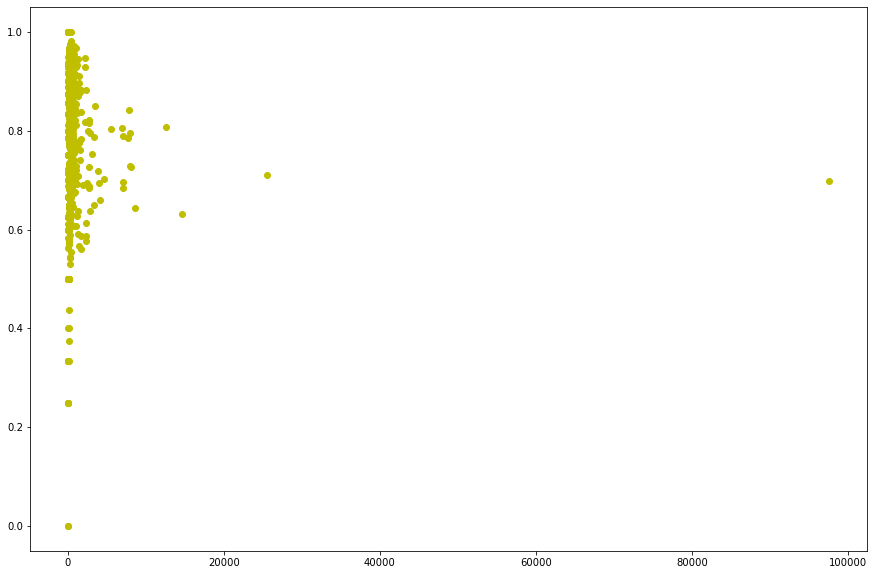

In [43]:
plt.figure(figsize=(15,10))
x = word_prob_count['prob']
y = [int(c) for c in word_prob_count['count']]
plt.scatter(y,x, c ="y")

# Reference

Training:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html